# H1: Do orofacial rhythm phases modulate decision performance?

## **Scope & hypothesis:**

*Goal:* Test whether the phase of an orofacial rhythm (whisker motion energy as a proxy; nose PC1 as secondary) at stimulus onset relates to reaction time (RT) and accuracy.

Primary dataset unit: one IBL session (~500 trials), then replicate.

Primary window: start with pre-stim (−1.0→0 s; later 0.5 s), then peri-stim (0→0.2 s, clipped by RT).

Primary oscillator: RIGHT-camera whisker motion energy (150 Hz). LEFT and nose PC1 used for quanlity control.

## **Data inputs (per session)**

trial_data_df: stimOn_times, firstMovement_times, feedbackType, contrast (signedContrast or L/R), optional probabilityLeft.

left_motion_energy_df / right_motion_energy_df: times, whiskerMotionEnergy.

left_pose_df / right_pose_df: times, nose_tip_x, nose_tip_y (for computing nose_pc1).

All signals in common session time base.

## **Preprocessing**

Nose PC1 (deterministic): SVD on demeaned [nose_x, nose_y]; fix sign so X-loading ≥ 0 → nose_pc1.

Uniform grid: Build at native FPS (≈60 Hz LEFT, ≈150 Hz RIGHT). Linear-interp each signal to the grid; NaN outside span.

Band-pass: IIR (order 3) Butterworth.

Pre-stim QC: 4–12 Hz, then 5–10 Hz if needed.

Peri-stim: 5–10 Hz.

Analytic signal: Hilbert → instantaneous phase (unwrap then wrap to [−π, π)) and amplitude.


## **Rhythm QC (gate the method, not trials)**

Segments: pre-stim windows (−1 s; then 0.5 s). Require ≥80% finite samples.

Coverage: ≥50% of trials contribute valid segments → PASS/FAIL.

Oscillatory structure: ACF first peak within band period ≥ 0.10 → PASS/FAIL.

Dominance: in-band PSD / flank PSD ≥ 1.30 (global, then median-over-trials if needed) → PASS/FAIL.

Coupling (optional): nose↔whisker coherence (non-gating).

Amplitude sweep (optional): percentile gating (40/60/80%) to probe SNR; do not hard-drop in final models.

Decision rule: proceed if either whisker ME or nose PC1 satisfies coverage + ACF and is near-threshold PSD dominance (no threshold lowering). Otherwise pivot directly to peri-stim.

## **Feature construction**

Pre-stim features (0.5 s):

- phaseAtStim: phase at stimOn_times (interpolated on unwrapped phase).

- ampPreStim: mean Hilbert amplitude over [−0.5 s, 0).

Peri-stim features (0–0.2 s):

- phaseAtStim (same method), ampPostStim: mean amplitude in [0, min(0.2 s, RT)].

- Outcomes: rt = firstMovement_times − stimOn_times; correct = (feedbackType==1).

Controls: absContrast = |signedContrast|; winDurUsed (peri-stim only).

Trial validity: ≥80% finite samples in the analyzed window; RT bounds 0.08–2.0 s for RT models.

Artifacts saved: H1_prestim_phase_features.csv and H1_peristim_phase_features.csv (+ PNG plots).

## **Modeling (amplitude-aware; phase as sin/cos)**

Why sin/cos: avoids circularity; tests first-harmonic phase effect jointly.

RT models (primary):

- Screen: OLS on RT with robust SE → only for diagnostics.

- Sane estimator: RLM (Tukey biweight) on log-RT with predictors
cos(phase), sin(phase), ampNorm, absContrast [, winDurUsed] + intercept.

- Report: joint Wald χ² for {cos, sin}; effect size = exp(2·sqrt(β_cos²+β_sin²)) (peak↔trough RT factor).

Accuracy models (secondary):

- GLM Binomial (logit) with robust SE (HC1): same predictors.

- Report: joint Wald for {cos, sin}; effect size = prob peak↔trough at p≈0.5 from log-odds amplitude.

Subsets tested:

- Low-contrast: absContrast ≤ 0.12 (phase most likely to matter). (NOTE: SEE IF THERE IS A MORE INFORMED NUMBER FOR LOW CONTRAST)

- Zero-contrast: absContrast == 0 (prior-dominated; if n≥50).

## **Promising vs. null criteria**

Promising (per subset): joint p < 0.01 and a plausible RT peak↔trough factor (≤ ~1.25) or accuracy Δprob (≤ ~0.1–0.2).

Null: p ≥ 0.01 (or implausible effect sizes even if p small) → reject H1 for that window/session.

## **Reporting (per session)**

QC summary: coverage %, ACF peak, PSD ratio(s), MRL of phase.

Model outputs: n, χ²(2), p, RT peak↔trough factor (and/or Δprob), coefficients for ampNorm, absContrast.

Conclusion: PASS/FAIL per window; call out outlier sensitivity if OLS and RLM disagree.

Next step: If pre-stim fails, pivot to peri-stim; if peri-stim also fails, move to H2 (neural phase-locking) or replicate H1 in additional sessions.

## **Known limitations / mitigations**

Respiration proxy: whisker ME (and nose PC1) only approximate sniffing; coupling can vary → treat amplitude as covariate and report coherence descriptives.

Quiescence pre-stim: low SNR likely → justify peri-stim pivot.

Single-session inference: avoid claims until replicated.

# 0. Preamble / Config

Session EID, bands, windows, FPS targets, thresholds (ACF≥0.10, PSD ratio≥1.30), RT bounds.

Assert required columns; set random seed; small helpers (logging, interpolation).

In [ ]:
! pip install ONE-api
! pip install ibllib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 7.4 MB/s eta 0:00

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SAVE_DIR = '/content/drive/MyDrive/S25/Langone/Breathing/Figures/hoferlab'

In [ ]:
from one.api import ONE
from brainbox.io.one import SessionLoader
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')
eid = '88d24c31-52e4-49cc-9f32-6adbeb9eba87'
sl = SessionLoader(one=one, eid=eid)

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


In [ ]:
sl.load_session_data(trials=True, motion_energy=True, reload=False)

2025-10-16 23:23:17 INFO     one.py:1475 Loading trials data


INFO:ibllib:Loading trials data
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.50k/4.50k [00:00<00:00, 65.0kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_trials.table.pqt: 100%|██████████| 46.0k/46.0k [00:00<00:00, 751kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.50k/4.50k [00:00<00:00, 92.4kB/s]


2025-10-16 23:23:21 INFO     one.py:1475 Loading wheel data


INFO:ibllib:Loading wheel data
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 14.1M/14.1M [00:00<00:00, 22.2MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_wheel.position.npy: 100%|██████████| 14.1M/14.1M [00:00<00:00, 39.2MB/s]


2025-10-16 23:23:26 INFO     one.py:1475 Loading pose data


INFO:ibllib:Loading pose data
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_leftCamera.times.npy: 100%|██████████| 2.09M/2.09M [00:00<00:00, 14.5MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_leftCamera.dlc.pqt: 100%|██████████| 39.3M/39.3M [00:00<00:00, 42.4MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_rightCamera.times.npy: 100%|██████████| 5.23M/5.23M [00:00<00:00, 8.17MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_rightCamera.dlc.pqt: 100%|██████████| 91.3M/91.3M [00:01<00:00, 57.6MB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/_ibl_bodyCamera.times.npy: 100%|██████████| 1.04M/1.04M [00:00<00:00, 5.25MB/s]
(S3) /root/Downloads/ONE/openalyx.international

2025-10-16 23:23:34 INFO     one.py:1475 Loading motion_energy data



INFO:ibllib:Loading motion_energy data
/usr/local/lib/python3.12/dist-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-05-30"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/#2025-05-30#/leftCamera.ROIMotionEnergy.npy: 100%|██████████| 2.09M/2.09M [00:00<00:00, 14.3MB/s]
/usr/local/lib/python3.12/dist-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-06-01"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/#2025-06-01#/rightCamera.ROIMotionEnergy.npy: 100%|██████████| 5.23M/5.23M [00:00<00:00, 15.5MB/s]
/usr/local/lib/python3.12/dist-packages/one/util.py:436: ALFWarning: Multiple revisions: "", "2025-06-02"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /root/Downloads/ONE/

2025-10-16 23:23:39 INFO     one.py:1475 Loading pupil data



INFO:ibllib:Loading pupil data
/usr/local/lib/python3.12/dist-packages/one/util.py:436: ALFWarning: Multiple revisions: "2025-06-04", ""
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-19/001/alf/#2025-06-04#/_ibl_leftCamera.features.pqt: 100%|██████████| 4.75M/4.75M [00:00<00:00, 12.8MB/s]


In [ ]:
# SECTION 0 — Preamble / Config / Sanity (run once)

import numpy as np, pandas as pd, warnings

# ---------------- Config (edit here) ----------------
np.random.seed(2025)  # reproducibility
cfg = {
    "eid": globals().get("eid", None),
    "bands": {           # analysis bands
        "prestim": (5.0, 10.0),
        "peristim": (5.0, 10.0),
        "broad":   (4.0, 12.0)
    },
    "windows": {         # seconds
        "prestimSec": 0.5,
        "peristimMaxSec": 0.2
    },
    "fpsTargets": {      # nominal FPS
        "left": 60.0,
        "right": 150.0
    },
    "thresholds": {      # QC thresholds
        "acfMinPeak": 0.10,
        "psdRatio": 1.30,
        "minSegCoverage": 0.80,
        "minTrialKeepFrac": 0.50
    },
    "rtBoundsSec": (0.08, 2.00)  # sane RT range
}

# ---------------- Small helpers ----------------
def log(msg):
    print(msg, flush=True)

def checkColumns(df, requiredCols, name):
    missing = [c for c in requiredCols if c not in df.columns]
    if missing:
        log(f"[FAIL] {name}: missing columns {missing}")
        return False
    log(f"[PASS] {name}: columns OK")
    return True

def estimateFs(times):
    times = np.asarray(times)
    dt = np.diff(times[np.isfinite(times)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tMin, tMax, fs):
    n = int(np.floor((tMax - tMin) * fs)) + 1
    return tMin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    m = np.isfinite(times) & np.isfinite(values)
    if m.sum() < 2:
        return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[m]); tt = times[m][idx]; vv = values[m][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

# ---------------- Assertions / Sanity ----------------
# Trials
trialDataDf = pd.DataFrame(sl.trials)
okTrials = checkColumns(
    trialDataDf,
    ['stimOn_times','firstMovement_times','feedbackType'],
    "Trials base"
)
hasSigned = 'signedContrast' in trialDataDf.columns
hasLR = {'contrastLeft','contrastRight'}.issubset(trialDataDf.columns)
if not (hasSigned or hasLR):
    log("[FAIL] Trials contrasts: need 'signedContrast' or both 'contrastLeft' & 'contrastRight'")
else:
    log(f"[PASS] Trials contrasts: {'signedContrast' if hasSigned else 'contrastLeft/right'} available")

# Motion energy (LEFT/RIGHT)
leftMEDf  = pd.DataFrame(getattr(getattr(sl, 'motion_energy', {}), 'get', lambda *_: {})('leftCamera'))
rightMEDf = pd.DataFrame(getattr(getattr(sl, 'motion_energy', {}), 'get', lambda *_: {})('rightCamera'))

okLeft  = (not leftMEDf.empty)  and checkColumns(leftMEDf,  ['times','whiskerMotionEnergy'], "LEFT motion energy")
okRight = (not rightMEDf.empty) and checkColumns(rightMEDf, ['times','whiskerMotionEnergy'], "RIGHT motion energy")
if not (okLeft or okRight):
    raise RuntimeError("No usable motion energy found (LEFT/RIGHT). Load at least one camera.")

# FPS report
if okLeft:
    fsLeft = estimateFs(leftMEDf['times'].values);  log(f"[INFO] LEFT ME fs≈{fsLeft:.2f} Hz (target {cfg['fpsTargets']['left']:.0f})")
if okRight:
    fsRight = estimateFs(rightMEDf['times'].values); log(f"[INFO] RIGHT ME fs≈{fsRight:.2f} Hz (target {cfg['fpsTargets']['right']:.0f})")

# Timebase overlap check (between trials and any ME present)
tMinTrials, tMaxTrials = float(np.nanmin(trialDataDf['stimOn_times'])), float(np.nanmax(trialDataDf['stimOn_times']))
spans = []
if okLeft:  spans.append(("LEFT",  float(leftMEDf['times'].min()),  float(leftMEDf['times'].max())))
if okRight: spans.append(("RIGHT", float(rightMEDf['times'].min()), float(rightMEDf['times'].max())))
for name, tMin, tMax in spans:
    overlap = (tMin <= tMaxTrials) and (tMax >= tMinTrials)
    log(f"[{'PASS' if overlap else 'FAIL'}] Timebase overlap {name} vs Trials: "
        f"{'yes' if overlap else 'no'} (ME {tMin:.2f}–{tMax:.2f}s, Trials {tMinTrials:.2f}–{tMaxTrials:.2f}s)")

log(f"\n[READY] Section 0 complete for EID={cfg['eid']}. Bands={cfg['bands']}, Windows={cfg['windows']}, "
    f"Thresholds={cfg['thresholds']}, RT bounds={cfg['rtBoundsSec']}.\n")


[PASS] Trials base: columns OK
[PASS] Trials contrasts: contrastLeft/right available
[PASS] LEFT motion energy: columns OK
[PASS] RIGHT motion energy: columns OK
[INFO] LEFT ME fs≈59.77 Hz (target 60)
[INFO] RIGHT ME fs≈150.02 Hz (target 150)
[PASS] Timebase overlap LEFT vs Trials: yes (ME 53.02–4413.86s, Trials 53.60–3032.15s)
[PASS] Timebase overlap RIGHT vs Trials: yes (ME 53.01–4413.88s, Trials 53.60–3032.15s)

[READY] Section 0 complete for EID=88d24c31-52e4-49cc-9f32-6adbeb9eba87. Bands={'prestim': (5.0, 10.0), 'peristim': (5.0, 10.0), 'broad': (4.0, 12.0)}, Windows={'prestimSec': 0.5, 'peristimMaxSec': 0.2}, Thresholds={'acfMinPeak': 0.1, 'psdRatio': 1.3, 'minSegCoverage': 0.8, 'minTrialKeepFrac': 0.5}, RT bounds=(0.08, 2.0).



In [ ]:
# SECTION 1 — Trials baseline QC & contrast normalization

def prepareTrials(trialDf, cfg):
    """
    Ensure contrast features exist and are sane; compute RT and validity masks;
    warn on pathological entries; check ME coverage for analysis windows.
    """
    log("== Trials: contrast normalization & RT QC ==")

    # --- Derive signedContrast if absent ---
    if 'signedContrast' not in trialDf.columns:
        cl = trialDf.get('contrastLeft',  pd.Series(np.nan, index=trialDf.index)).astype(float)
        cr = trialDf.get('contrastRight', pd.Series(np.nan, index=trialDf.index)).astype(float)
        trialDf = trialDf.assign(signedContrast=(cr - cl))
        log("[INFO] Derived signedContrast = contrastRight - contrastLeft")
    else:
        log("[INFO] Using existing signedContrast")

    # --- Sanity on contrast scales / conflicts ---
    sc = trialDf['signedContrast'].astype(float)
    if (np.abs(sc) > 1.0 + 1e-9).any():
        n_bad = int((np.abs(sc) > 1.0 + 1e-9).sum())
        log(f"[WARN] {n_bad} trials have |signedContrast|>1. Check units/scaling.")

    both_nonzero = ('contrastLeft' in trialDf.columns) and ('contrastRight' in trialDf.columns) and \
                   ((trialDf['contrastLeft'] > 0) & (trialDf['contrastRight'] > 0) &
                    (np.abs(trialDf['contrastLeft'] - trialDf['contrastRight']) > 1e-12))
    if isinstance(both_nonzero, pd.Series) and both_nonzero.any():
        n_both = int(both_nonzero.sum())
        log(f"[WARN] {n_both} trials have both sides nonzero (unexpected). Consider excluding or mapping to a side.")

    # --- Derived columns ---
    trialDf = trialDf.assign(
        absContrast=np.abs(trialDf['signedContrast'].astype(float)),
        rtSec=(trialDf['firstMovement_times'] - trialDf['stimOn_times']).astype(float)
    )

    # --- RT sanity & mask ---
    rt_lo, rt_hi = cfg['rtBoundsSec']
    rt_ok = trialDf['rtSec'].between(rt_lo, rt_hi) & np.isfinite(trialDf['rtSec'])
    n_total = len(trialDf); n_rtok = int(rt_ok.sum())
    log(f"[INFO] RT valid {n_rtok}/{n_total} "
        f"({100.0*n_rtok/n_total:.1f}%), bounds={cfg['rtBoundsSec']} s")

    # --- Contrast subset counts (for later modeling) ---
    n_zero = int((trialDf['absContrast'] == 0).sum())
    n_low  = int((trialDf['absContrast'] <= 0.12 + 1e-12).sum())
    log(f"[INFO] Zero-contrast n={n_zero}; Low-contrast (≤0.12) n={n_low}")

    # --- Window span checks vs ME availability (guard against silent drop) ---
    stim_min = float(np.nanmin(trialDf['stimOn_times']))
    stim_max = float(np.nanmax(trialDf['stimOn_times']))
    pre_half = float(cfg['windows']['prestimSec'])
    peri_win = float(cfg['windows']['peristimMaxSec'])

    # These will be filled by caller after ME loads; we just report desired spans here
    desired_min = stim_min - pre_half
    desired_max = stim_max + peri_win
    log(f"[INFO] Desired ME coverage: [{desired_min:.2f}, {desired_max:.2f}] s "
        f"(uses prestim {pre_half}s, peristim {peri_win}s)")

    # Basic time monotonicity guard
    bad_order = (trialDf['rtSec'] < 0).sum()
    if bad_order:
        log(f"[WARN] {int(bad_order)} trials have negative RT (firstMovement < stimOn). Will be excluded downstream.")

    # Stash masks
    trialDf = trialDf.assign(rtValid=rt_ok.values)
    return trialDf, dict(
        nTrials=n_total, nRtValid=n_rtok, nZero=n_zero, nLow=n_low,
        desiredCoverage=(desired_min, desired_max)
    )

trialDataDf, trialStats = prepareTrials(trialDataDf, cfg)
log(f"[READY] Trials normalized. Stats: {trialStats}")


== Trials: contrast normalization & RT QC ==
[INFO] Derived signedContrast = contrastRight - contrastLeft
[INFO] RT valid 328/547 (60.0%), bounds=(0.08, 2.0) s
[INFO] Zero-contrast n=0; Low-contrast (≤0.12) n=0
[INFO] Desired ME coverage: [53.10, 3032.35] s (uses prestim 0.5s, peristim 0.2s)
[WARN] 117 trials have negative RT (firstMovement < stimOn). Will be excluded downstream.
[READY] Trials normalized. Stats: {'nTrials': 547, 'nRtValid': 328, 'nZero': 0, 'nLow': 0, 'desiredCoverage': (53.096073190053595, 3032.354187593032)}


In [ ]:
# SECTION 1 — Data Load & Sanity: ME resampling & coverage (RIGHT primary, LEFT secondary)

from math import floor
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **k: x  # degrade gracefully if tqdm missing

def prepareME(meDf, targetFs, name):
    """
    Resample motion energy to a uniform grid at ~native fs and report NaN rate.
    """
    if meDf is None or meDf.empty:
        log(f"[WARN] {name}: empty ME dataframe")
        return dict(name=name, ok=False)

    times = meDf['times'].to_numpy(dtype=float)
    vals  = meDf['whiskerMotionEnergy'].to_numpy(dtype=float)

    fsEst = estimateFs(times)
    if not np.isfinite(fsEst) or fsEst < 1:
        log(f"[FAIL] {name}: could not estimate fs")
        return dict(name=name, ok=False)

    tMin, tMax = float(np.nanmin(times)), float(np.nanmax(times))
    gridFs = float(round(fsEst))  # stick to detected native rate
    grid   = buildGrid(tMin, tMax, gridFs)
    sig    = resampleToGrid(times, vals, grid)
    nanFrac = float(np.mean(~np.isfinite(sig)))
    log(f"[INFO] {name}: fs≈{fsEst:.2f} Hz, gridFs={gridFs:.0f}, span={tMin:.2f}–{tMax:.2f}s, NaN frac={nanFrac:.3f}")
    return dict(name=name, ok=True, grid=grid, sig=sig, fs=gridFs, span=(tMin, tMax))

def windowCoverage(grid, sig, t0, t1):
    """
    Fraction finite samples in [t0, t1) on this (grid, sig).
    """
    if not (np.isfinite(t0) and np.isfinite(t1)) or t1 <= t0:
        return np.nan
    i0 = max(0, int(floor((t0 - grid[0]) * (len(grid)-1) / (grid[-1]-grid[0] + 1e-12))))
    i1 = min(len(grid), int(floor((t1 - grid[0]) * (len(grid)-1) / (grid[-1]-grid[0] + 1e-12))) + 1)
    if i1 <= i0:
        return 0.0
    win = sig[i0:i1]
    return float(np.mean(np.isfinite(win)))

def computeCoverageMatrices(trialsDf, mePacked, cfg):
    """
    For each camera present, compute pre-stim and peri-stim coverage per trial.
    Peri-stim window is clipped by RT when valid.
    """
    preSec  = float(cfg['windows']['prestimSec'])
    periMax = float(cfg['windows']['peristimMaxSec'])
    covThr  = float(cfg['thresholds']['minSegCoverage'])

    out = {}
    for cam, pack in mePacked.items():
        if not pack.get('ok', False):
            continue
        grid, sig = pack['grid'], pack['sig']
        preCov  = np.full(len(trialsDf), np.nan, float)
        periCov = np.full(len(trialsDf), np.nan, float)

        log(f"[INFO] Coverage: computing on {cam} ({len(trialsDf)} trials)")
        for i in tqdm(range(len(trialsDf)), total=len(trialsDf), leave=False):
            stim = trialsDf.at[i, 'stimOn_times']
            rt   = trialsDf.at[i, 'rtSec'] if 'rtSec' in trialsDf.columns else np.nan

            # Pre-stim window: [stim - preSec, stim)
            preCov[i]  = windowCoverage(grid, sig, stim - preSec, stim)

            # Peri-stim window: [stim, stim + min(periMax, rtValid?rt:periMax))
            rtClip = periMax if not (isinstance(rt, (float, np.floating)) and np.isfinite(rt) and trialsDf.at[i, 'rtValid']) \
                     else min(periMax, float(rt))
            periCov[i] = windowCoverage(grid, sig, stim, stim + rtClip)

        keepPre  = np.isfinite(preCov)  & (preCov  >= covThr)
        keepPeri = np.isfinite(periCov) & (periCov >= covThr)

        out[cam] = dict(preCov=preCov, periCov=periCov, keepPre=keepPre, keepPeri=keepPeri,
                        fs=pack['fs'], span=pack['span'])

        nPre  = int(keepPre.sum());  nPeri = int(keepPeri.sum())
        log(f"[INFO] {cam}: pre-stim keep {nPre}/{len(trialsDf)} ({100*nPre/len(trialsDf):.1f}%) "
            f"| peri-stim keep {nPeri}/{len(trialsDf)} ({100*nPeri/len(trialsDf):.1f}%) "
            f"(thr≥{covThr:.2f})")

    return out

# ---- Run it
mePacks = {}
if okRight:
    mePacks['RIGHT'] = prepareME(rightMEDf, cfg['fpsTargets']['right'], "RIGHT ME")
if okLeft:
    mePacks['LEFT']  = prepareME(leftMEDf,  cfg['fpsTargets']['left'],  "LEFT ME")

coverage = computeCoverageMatrices(trialDataDf.reset_index(drop=True), mePacks, cfg)

# Quick gate: do we have ≥50% trials with valid pre-stim coverage on at least one source?
minKeepFrac = float(cfg['thresholds']['minTrialKeepFrac'])
preKeepFracRight = float(np.mean(coverage.get('RIGHT', {}).get('keepPre', np.array([], bool)))) if 'RIGHT' in coverage else 0.0
preKeepFracLeft  = float(np.mean(coverage.get('LEFT',  {}).get('keepPre', np.array([], bool)))) if 'LEFT'  in coverage else 0.0
log(f"[CHECK] Pre-stim keep fraction — RIGHT={preKeepFracRight:.2f}, LEFT={preKeepFracLeft:.2f}, "
    f"threshold={minKeepFrac:.2f}")


[INFO] RIGHT ME: fs≈150.02 Hz, gridFs=150, span=53.01–4413.88s, NaN frac=0.000
[INFO] LEFT ME: fs≈59.77 Hz, gridFs=60, span=53.02–4413.86s, NaN frac=0.000
[INFO] Coverage: computing on RIGHT (547 trials)


  0%|          | 0/547 [00:00<?, ?it/s]

[INFO] RIGHT: pre-stim keep 547/547 (100.0%) | peri-stim keep 547/547 (100.0%) (thr≥0.80)
[INFO] Coverage: computing on LEFT (547 trials)


  0%|          | 0/547 [00:00<?, ?it/s]

[INFO] LEFT: pre-stim keep 547/547 (100.0%) | peri-stim keep 547/547 (100.0%) (thr≥0.80)
[CHECK] Pre-stim keep fraction — RIGHT=1.00, LEFT=1.00, threshold=0.50


# 1. Data Load & Sanity

Load trial_data_df, left/right_motion_energy_df, left/right_pose_df.

PASS/FAIL: coverage, shared timebase, basic stats.

In [ ]:
trial_data_df = pd.DataFrame(sl.trials)

left_motion_energy_df = sl.motion_energy['leftCamera']
left_pose_df = pd.DataFrame(sl.pose['leftCamera'])

right_motion_energy_df = sl.motion_energy['rightCamera']
right_pose_df = pd.DataFrame(sl.pose['rightCamera'])

In [ ]:
# SECTION 1 — Data Load & Sanity Checks (uses dataframes you already created)

# ---- helpers (reuse from §0 if present) ----
def log(msg): print(msg, flush=True)

def estimateFs(times):
    t = np.asarray(times); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def check_cols(df, req, name):
    missing = [c for c in req if c not in df.columns]
    if missing:
        log(f"[FAIL] {name}: missing {missing}")
        return False
    log(f"[PASS] {name}: columns OK")
    return True

def timespan(df, name):
    tmin = float(df['times'].min()); tmax = float(df['times'].max())
    log(f"[INFO] {name}: time span {tmin:.3f}–{tmax:.3f}s")
    return tmin, tmax

# ---- 1) Trials sanity ----
ok = True
req_trials = ['stimOn_times','firstMovement_times','feedbackType']
ok &= check_cols(trial_data_df, req_trials, "Trials")
has_signed = 'signedContrast' in trial_data_df.columns
has_lr = {'contrastLeft','contrastRight'}.issubset(trial_data_df.columns)
if not (has_signed or has_lr):
    log("[FAIL] Trials: need 'signedContrast' or both 'contrastLeft' & 'contrastRight'"); ok = False
else:
    log(f"[PASS] Trials contrast: {'signedContrast' if has_signed else 'contrastLeft/right'} present")

n_trials = len(trial_data_df)
rt = trial_data_df['firstMovement_times'] - trial_data_df['stimOn_times']
rt_valid = rt[np.isfinite(rt)]
rt_valid = rt_valid[(rt_valid >= 0.08) & (rt_valid <= 2.0)]
acc = (trial_data_df['feedbackType'] == 1).astype(float)
absC = (trial_data_df['signedContrast'].abs()
        if has_signed else
        (trial_data_df['contrastRight'].fillna(0) - trial_data_df['contrastLeft'].fillna(0)).abs())
log(f"[INFO] Trials: n={n_trials}, RT valid={len(rt_valid)}/{n_trials} "
    f"(median {rt_valid.median():.3f}s), accuracy={acc.mean():.3f}")
log(f"[INFO] Contrast: zero={int((absC==0).sum())}, low(≤0.12)={int((absC<=0.12).sum())}")

# ---- 2) Motion energy sanity (LEFT/RIGHT) ----
def me_check(df, name):
    if isinstance(df, (pd.DataFrame,)) and not df.empty:
        ok_local = check_cols(df, ['times','whiskerMotionEnergy'], f"{name} ME")
        if not ok_local: return False, (np.nan, np.nan)
        fs = estimateFs(df['times'].values)
        cov = np.isfinite(df['whiskerMotionEnergy']).mean()
        mono = np.all(np.diff(df['times'].values) > 0)
        tmin, tmax = timespan(df, name+" ME")
        log(f"[INFO] {name} ME: fs≈{fs:.2f} Hz, finite={100*cov:.1f}%, times strictly increasing={mono}")
        return True, (tmin, tmax)
    else:
        log(f"[WARN] {name} ME: not available/empty")
        return False, (np.nan, np.nan)

okL, spanL = me_check(left_motion_energy_df,  "LEFT")
okR, spanR = me_check(right_motion_energy_df, "RIGHT")
ok &= (okL or okR)

# ---- 3) Pose sanity (LEFT/RIGHT) ----
def pose_check(df, name):
    if isinstance(df, (pd.DataFrame,)) and not df.empty:
        ok_local = check_cols(df, ['times','nose_tip_x','nose_tip_y'], f"{name} pose")
        if not ok_local: return False, (np.nan, np.nan)
        fs = estimateFs(df['times'].values)
        fx = np.isfinite(df['nose_tip_x']).mean(); fy = np.isfinite(df['nose_tip_y']).mean()
        tmin, tmax = timespan(df, name+" pose")
        log(f"[INFO] {name} pose: fs≈{fs:.2f} Hz, finite x={100*fx:.1f}%, y={100*fy:.1f}%")
        return True, (tmin, tmax)
    else:
        log(f"[WARN] {name} pose: not available/empty")
        return False, (np.nan, np.nan)

okLP, spanLP = pose_check(left_pose_df,  "LEFT")
okRP, spanRP = pose_check(right_pose_df, "RIGHT")
ok &= (okLP or okRP)

# ---- 4) Timebase overlap vs trials ----
tmin_trials = float(trial_data_df['stimOn_times'].min())
tmax_trials = float(trial_data_df['stimOn_times'].max())

def overlap(span, name):
    tmin, tmax = span
    if np.isnan(tmin) or np.isnan(tmax):
        log(f"[WARN] Overlap {name}: skipped (no span)"); return True
    good = (tmin <= tmax_trials) and (tmax >= tmin_trials)
    log(f"[{'PASS' if good else 'FAIL'}] Overlap {name} vs trials: {'yes' if good else 'no'}")
    return good

ok &= overlap(spanL, "LEFT ME")
ok &= overlap(spanR, "RIGHT ME")
ok &= overlap(spanLP, "LEFT pose")
ok &= overlap(spanRP, "RIGHT pose")

# ---- 5) Final verdict for Section 1 ----
log(f"\n[READY/SECTION 1] {'PASS' if ok else 'FAIL'} — "
    f"Trials/ME/Pose present and time-aligned. Proceed to §2 (Nose PC1) if PASS.")


[PASS] Trials: columns OK
[PASS] Trials contrast: contrastLeft/right present
[INFO] Trials: n=547, RT valid=328/547 (median 0.220s), accuracy=0.797
[INFO] Contrast: zero=65, low(≤0.12)=185
[PASS] LEFT ME: columns OK
[INFO] LEFT ME: time span 53.016–4413.863s
[INFO] LEFT ME: fs≈59.77 Hz, finite=100.0%, times strictly increasing=True
[PASS] RIGHT ME: columns OK
[INFO] RIGHT ME: time span 53.009–4413.881s
[INFO] RIGHT ME: fs≈150.02 Hz, finite=100.0%, times strictly increasing=True
[PASS] LEFT pose: columns OK
[INFO] LEFT pose: time span 53.016–4413.863s
[INFO] LEFT pose: fs≈59.77 Hz, finite x=99.2%, y=99.2%
[PASS] RIGHT pose: columns OK
[INFO] RIGHT pose: time span 53.009–4413.881s
[INFO] RIGHT pose: fs≈150.02 Hz, finite x=99.8%, y=99.8%
[PASS] Overlap LEFT ME vs trials: yes
[PASS] Overlap RIGHT ME vs trials: yes
[PASS] Overlap LEFT pose vs trials: yes
[PASS] Overlap RIGHT pose vs trials: yes

[READY/SECTION 1] PASS — Trials/ME/Pose present and time-aligned. Proceed to §2 (Nose PC1) if PA

In [ ]:
# SECTION 1a — Contrast audit (resolve zero/low-contrast mismatch)

import numpy as np
import pandas as pd

def log(msg):
    print(msg, flush=True)

def auditContrasts(trialDf):
    """
    Verify signedContrast derivation and distribution.
    Checks for: (a) presence/consistency of signedContrast,
                 (b) both-nonzero anomalies,
                 (c) zero/low-contrast counts,
                 (d) unit/scale sanity.
    """
    df = trialDf.copy()

    hasSigned = 'signedContrast' in df.columns
    hasLR = {'contrastLeft','contrastRight'}.issubset(df.columns)

    if not hasSigned and not hasLR:
        log("[FAIL] Need either signedContrast or both contrastLeft & contrastRight.")
        return df

    if hasLR:
        cl = df['contrastLeft'].astype(float).fillna(0.0)
        cr = df['contrastRight'].astype(float).fillna(0.0)
        derivedSigned = (cr - cl).astype(float)
        df['derivedSignedContrast'] = derivedSigned
        log("[INFO] derivedSignedContrast = contrastRight - contrastLeft")

    if hasSigned:
        df['signedContrast'] = df['signedContrast'].astype(float)
        log("[INFO] signedContrast exists in dataframe")

    # Compare existing signedContrast (if present) to derived
    if hasSigned and hasLR:
        mismatch = ~np.isclose(df['signedContrast'], df['derivedSignedContrast'], atol=1e-9, rtol=0)
        nMismatch = int(mismatch.sum())
        log(f"[CHECK] signedContrast vs derived: mismatches={nMismatch}/{len(df)}")
        if nMismatch:
            ex = df.loc[mismatch, ['contrastLeft','contrastRight','signedContrast','derivedSignedContrast']].head(5)
            log(f"[EXAMPLE] First 5 mismatches:\n{ex}")

    # Adopt a single source of truth
    sc = df['signedContrast'] if hasSigned else df['derivedSignedContrast']
    df['signedContrast_clean'] = sc.astype(float)
    df['absContrast'] = df['signedContrast_clean'].abs()

    # Zero / low counts
    nZero = int((df['absContrast'] == 0).sum())
    nLow  = int((df['absContrast'] <= 0.12 + 1e-12).sum())
    log(f"[INFO] Contrast counts: zero={nZero}, low(≤0.12)={nLow}, total={len(df)}")

    # Value distribution (rounded)
    vc = df['absContrast'].round(4).value_counts().sort_index()
    log("[INFO] absContrast value_counts (rounded to 4dp):")
    print(vc.to_string())

    # Both-nonzero anomaly check
    if hasLR:
        bothNonzero = (cl > 0) & (cr > 0) & (np.abs(cl - cr) > 1e-12)
        nBoth = int(bothNonzero.sum())
        log(f"[CHECK] Trials with both sides nonzero (unexpected): {nBoth}")
        if nBoth:
            ex2 = df.loc[bothNonzero, ['contrastLeft','contrastRight']].head(5)
            log(f"[EXAMPLE] First 5 both-nonzero:\n{ex2}")

        # Range sanity
        log(f"[INFO] contrastLeft range:  [{cl.min():.3f}, {cl.max():.3f}]")
        log(f"[INFO] contrastRight range: [{cr.min():.3f}, {cr.max():.3f}]")

    # RT cross-check (optional, for context)
    if {'stimOn_times','firstMovement_times'}.issubset(df.columns):
        rtSec = (df['firstMovement_times'] - df['stimOn_times']).astype(float)
        nNeg = int((rtSec < 0).sum())
        log(f"[INFO] Negative RT trials (firstMovement < stimOn): {nNeg}")

    return df

_ = auditContrasts(trial_data_df if 'trial_data_df' in globals() else trialDataDf)


[INFO] derivedSignedContrast = contrastRight - contrastLeft
[INFO] Contrast counts: zero=65, low(≤0.12)=185, total=547
[INFO] absContrast value_counts (rounded to 4dp):
absContrast
0.0000     65
0.0625    120
0.1250    130
0.2500    113
1.0000    119
[CHECK] Trials with both sides nonzero (unexpected): 0
[INFO] contrastLeft range:  [0.000, 1.000]
[INFO] contrastRight range: [0.000, 1.000]
[INFO] Negative RT trials (firstMovement < stimOn): 117


# 2. Nose PC1 (Deterministic)

SVD PC1 from (nose_tip_x, nose_tip_y); fix sign (X-loading ≥ 0).

Save nose_pc1; quick preview.

In [ ]:
# SECTION 2 — Nose PC1 (Deterministic; sign fixed so X-loading ≥ 0)

import numpy as np
import pandas as pd

def log(msg):
    print(msg, flush=True)

def compute_nose_pc1(poseDf: pd.DataFrame, sideLabel: str):
    """Compute deterministic PC1 for (nose_tip_x, nose_tip_y); sign fixed by X-loading ≥ 0.
    Adds column 'nose_pc1' in-place and returns a summary dict."""
    req = {'times','nose_tip_x','nose_tip_y'}
    if poseDf is None or poseDf.empty or not req.issubset(poseDf.columns):
        log(f"[FL] {sideLabel} pose missing required columns {req}. Skipping.")
        return {"side": sideLabel, "ok": False}

    # Finite mask and centering
    X = poseDf[['nose_tip_x','nose_tip_y']].to_numpy(dtype=float)
    mask = np.isfinite(X).all(axis=1)
    if mask.sum() < 10:
        log(f"[FAIL] {sideLabel} pose has insufficient finite samples ({mask.sum()}).")
        poseDf['nose_pc1'] = np.nan
        return {"side": sideLabel, "ok": False}

    Xm = X[mask] - X[mask].mean(axis=0)

    # SVD on centered data (deterministic)
    U, S, VT = np.linalg.svd(Xm, full_matrices=False)
    comp = VT[0, :]                     # principal axis
    if comp[0] < 0: comp = -comp        # fix sign so loading on X ≥ 0

    # Scores (project centered data along comp)
    scores = np.full(len(X), np.nan, dtype=float)
    scores[mask] = Xm @ comp

    # Variance explained by PC1
    var_ratio = (S[0]**2) / np.sum(S**2) if S.size else np.nan

    # Write back
    poseDf['nose_pc1'] = scores

    log(f"[PASS] {sideLabel} nose PC1: loading=[{comp[0]:.4f}, {comp[1]:.4f}] "
        f"varExplained={var_ratio:.3f} finiteCoverage={mask.mean():.3f}")

    # Quick preview
    preview = poseDf.loc[mask, ['times','nose_tip_x','nose_tip_y','nose_pc1']].head(5)
    print(preview.to_string(index=False))

    return {
        "side": sideLabel, "ok": True,
        "loading_x": float(comp[0]), "loading_y": float(comp[1]),
        "var_explained": float(var_ratio), "finite_coverage": float(mask.mean())
    }

# ---- Run for LEFT and RIGHT (if available) ----
summaries = []
if 'left_pose_df' in globals():
    summaries.append(compute_nose_pc1(left_pose_df,  "LEFT"))
else:
    log("[WARN] LEFT pose dataframe not found in scope.")

if 'right_pose_df' in globals():
    summaries.append(compute_nose_pc1(right_pose_df, "RIGHT"))
else:
    log("[WARN] RIGHT pose dataframe not found in scope.")

log("\n[READY/SECTION 2] Nose PC1 added as column 'nose_pc1' where available.")


[PASS] LEFT nose PC1: loading=[0.5592, -0.8290] varExplained=0.912 finiteCoverage=0.992
    times  nose_tip_x  nose_tip_y  nose_pc1
53.032296  370.460114  260.480095 -2.769100
53.049028  370.460114  261.083279 -3.269150
53.065760  370.301231  261.228287 -3.478214
53.082491  370.307472  261.458275 -3.665388
53.099223  370.269238  261.508690 -3.728565
[PASS] RIGHT nose PC1: loading=[0.3587, 0.9334] varExplained=0.904 finiteCoverage=0.998
    times  nose_tip_x  nose_tip_y  nose_pc1
53.009399  470.435009  146.195812  0.744413
53.029397  470.435009  146.200155  0.748467
53.036063  470.435009  146.262251  0.806430
53.042729  470.519844  146.262251  0.836861
53.049395  470.708464  146.465441  1.094189

[READY/SECTION 2] Nose PC1 added as column 'nose_pc1' where available.


# 3. Rhythm QC — Pre-stim (−1→0 s, then 0.5 s)

Build uniform grid; band-pass (4–12, then 5–10 Hz).

Metrics: coverage, PSD ratio (global & median-over-trials), ACF peak, optional coherence (nose↔whisker).

Amplitude sweep (40/60/80%) for SNR probing (non-gating).

PASS/FAIL summary; decision to proceed or pivot.

In [ ]:
# SECTION 3A — Rhythm QC (pre-stim −1→0 s): 4–12 Hz, fallback to 5–10 Hz if needed

import numpy as np
from math import floor, ceil
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **k: x
from scipy.signal import butter, filtfilt, hilbert, welch, find_peaks

def log(msg): print(msg, flush=True)

def estimateFs(times):
    t = np.asarray(times); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tMin, tMax, fs):
    n = int(np.floor((tMax - tMin) * fs)) + 1
    return tMin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    m = np.isfinite(times) & np.isfinite(values)
    if m.sum() < 2:
        return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[m]); tt = times[m][idx]; vv = values[m][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

def designBandpass(fs, fLo, fHi, order=3):
    nyq = 0.5 * float(fs)
    if not (0 < fLo < fHi < nyq):
        raise ValueError(f"Bad band [{fLo}, {fHi}] for fs={fs} (nyq={nyq})")
    wn = [fLo/nyq, fHi/nyq]
    b, a = butter(order, wn, btype='bandpass', output='ba')
    return b, a

def extractWindow(grid, sig, t0, t1):
    if t1 <= t0: return np.array([], dtype=float)
    idx0 = max(0, int(floor((t0 - grid[0]) * (len(grid)-1) / (grid[-1]-grid[0] + 1e-12))))
    idx1 = min(len(grid), int(floor((t1 - grid[0]) * (len(grid)-1) / (grid[-1]-grid[0] + 1e-12))) + 1)
    if idx1 <= idx0: return np.array([], dtype=float)
    return sig[idx0:idx1]

def analyticPhaseAmp(x):
    z = hilbert(x)
    phase = np.unwrap(np.angle(z))
    phaseWrapped = (phase + np.pi) % (2*np.pi) - np.pi
    amp = np.abs(z)
    return phase, phaseWrapped, amp

def acfFirstPeak(x, fs, fLo, fHi):
    x = np.asarray(x, float)
    x = x - np.nanmean(x)
    if x.size < 8 or np.allclose(np.std(x), 0): return np.nan, np.nan
    ac = np.correlate(x, x, mode='full'); ac = ac[ac.size//2:]
    if ac[0] == 0: return np.nan, np.nan
    ac = ac / ac[0]
    lagMin = max(1, int(floor(fs / float(fHi))))
    lagMax = min(len(ac)-1, int(ceil(fs / float(fLo))))
    if lagMax <= lagMin: return np.nan, np.nan
    peaks, _ = find_peaks(ac[lagMin:lagMax+1])
    if peaks.size == 0: return np.nan, np.nan
    firstIdx = peaks[0] + lagMin
    return float(ac[firstIdx]), float(firstIdx / fs)

def bandPowerRatio(x, fs, band, flankWidth=None):
    x = np.asarray(x, float)
    if x.size < 16 or np.allclose(np.std(x), 0): return np.nan
    nperseg = max(16, min(256, 2**int(np.floor(np.log2(len(x))))))
    f, pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=nperseg//2, detrend='constant', scaling='density')
    fLo, fHi = map(float, band)
    w = float(flankWidth) if flankWidth is not None else (fHi - fLo)
    fL0, fL1 = max(0.5, fLo - w), fLo
    fH0, fH1 = fHi, fHi + w
    def pwr(f0, f1):
        m = (f >= f0) & (f < f1)
        return np.trapz(pxx[m], f[m]) if np.any(m) else np.nan
    pBand = pwr(fLo, fHi); pFlL = pwr(fL0, fL1); pFlH = pwr(fH0, fH1)
    pFlank = np.nanmean([pFlL, pFlH])
    if not (np.isfinite(pBand) and np.isfinite(pFlank) and pFlank > 0): return np.nan
    return float(pBand / pFlank)

def qcPrestimForME(meDf, trialsDf, bandPrimary=(4.0,12.0), bandFallback=(5.0,10.0),
                   acfThr=0.10, psdThr=1.30, label="RIGHT"):
    """Pre-stim QC for one ME source using −1→0 s windows."""
    fsEst = estimateFs(meDf['times'].values)
    tMin, tMax = float(meDf['times'].min()), float(meDf['times'].max())
    gridFs = float(round(fsEst))
    grid   = buildGrid(tMin, tMax, gridFs)
    sig    = resampleToGrid(meDf['times'].values, meDf['whiskerMotionEnergy'].values, grid)
    if np.any(~np.isfinite(sig)):
        # fill short gaps defensively
        bad = ~np.isfinite(sig)
        goodIdx = np.where(~bad)[0]
        sig[bad] = np.interp(np.where(bad)[0], goodIdx, sig[goodIdx])

    def runBand(band, tag):
        b, a = designBandpass(gridFs, band[0], band[1], order=3)
        sigBP = filtfilt(b, a, sig, method="pad")
        n = len(trialsDf)
        acfPeaks = np.full(n, np.nan, float)
        acfLags  = np.full(n, np.nan, float)
        psdRatios = np.full(n, np.nan, float)
        phaseAtStim = np.full(n, np.nan, float)
        ampPreMean  = np.full(n, np.nan, float)
        segs = []
        for i in tqdm(range(n), total=n, leave=False):
            stim = float(trialsDf.at[i, 'stimOn_times'])
            seg = extractWindow(grid, sigBP, stim - 1.0, stim)  # −1→0 s for QC
            if seg.size == 0 or not np.isfinite(seg).all():
                continue
            segs.append(seg)
            _, phaseWrapped, amp = analyticPhaseAmp(seg)
            phaseAtStim[i] = float(phaseWrapped[-1])
            ampPreMean[i]  = float(np.mean(amp))
            pk, lag = acfFirstPeak(seg, gridFs, band[0], band[1])
            acfPeaks[i], acfLags[i] = pk, lag
            psdRatios[i] = bandPowerRatio(seg, gridFs, band)
        pooled = np.concatenate(segs) if segs else np.array([], float)
        pooledRatio = bandPowerRatio(pooled, gridFs, band) if pooled.size else np.nan

        keepAcf = np.isfinite(acfPeaks) & (acfPeaks >= acfThr)
        medAcf  = float(np.nanmedian(acfPeaks)) if np.isfinite(acfPeaks).any() else np.nan
        medLag  = float(np.nanmedian(acfLags))  if np.isfinite(acfLags).any()  else np.nan
        medPsd  = float(np.nanmedian(psdRatios)) if np.isfinite(psdRatios).any() else np.nan
        passAcf = bool(np.nanmedian(keepAcf) >= 0.5)
        passPsd = bool((np.isfinite(medPsd) and medPsd >= psdThr) or
                       (np.isfinite(pooledRatio) and pooledRatio >= psdThr))

        log(f"[QC/{label}/{tag}] ACF: medPeak={medAcf:.3f} thr≥{acfThr:.2f}; "
            f"medLag≈{medLag:.3f}s (expect {1/band[1]:.3f}–{1/band[0]:.3f}s); pass={passAcf}")
        log(f"[QC/{label}/{tag}] PSD: median={medPsd:.2f}, pooled={pooledRatio:.2f}; thr≥{psdThr:.2f}; pass={passPsd}")

        # Descriptive concentration
        validPhase = np.isfinite(phaseAtStim)
        mrl = float(np.hypot(np.nanmean(np.cos(phaseAtStim[validPhase])),
                             np.nanmean(np.sin(phaseAtStim[validPhase])))) if validPhase.any() else np.nan
        log(f"[DESC/{label}/{tag}] MRL(phaseAtStim)={mrl:.3f}")

        return dict(band=band, medAcf=medAcf, medLag=medLag, medPsd=medPsd, pooledPsd=pooledRatio,
                    passAcf=passAcf, passPsd=passPsd, phaseAtStim=phaseAtStim, ampPreMean=ampPreMean)

    log(f"\n== Pre-stim QC start: {label} fs≈{gridFs}Hz, span {tMin:.2f}–{tMax:.2f}s ==")
    resPrimary  = runBand(bandPrimary,  tag="4-12")
    if resPrimary['passAcf'] and resPrimary['passPsd']:
        chosen = resPrimary
        chosen['bandTag'] = "4-12"
        log(f"[DECISION/{label}] Using 4–12 Hz for pre-stim (passes).")
    else:
        log(f"[DECISION/{label}] 4–12 Hz failed or marginal → trying 5–10 Hz.")
        resFallback = runBand(bandFallback, tag="5-10")
        chosen = resFallback
        chosen['bandTag'] = "5-10"
    return dict(fs=gridFs, grid=(tMin, tMax), label=label, **chosen)

# ---- Run for RIGHT first (preferred), then LEFT
acfThr = cfg['thresholds']['acfMinPeak']; psdThr = cfg['thresholds']['psdRatio']
qcRight = qcPrestimForME(right_motion_energy_df, trial_data_df, bandPrimary=cfg['bands']['broad'],
                         bandFallback=cfg['bands']['prestim'], acfThr=acfThr, psdThr=psdThr, label="RIGHT")
qcLeft  = qcPrestimForME(left_motion_energy_df,  trial_data_df, bandPrimary=cfg['bands']['broad'],
                         bandFallback=cfg['bands']['prestim'], acfThr=acfThr, psdThr=psdThr, label="LEFT")

def choosePrestimSource(qcR, qcL):
    def ok(q): return q['passAcf'] and q['passPsd']
    choice = 'RIGHT' if ok(qcR) else ('LEFT' if ok(qcL) else None)
    log(f"[DECISION] Pre-stim source = {choice if choice else 'NONE (pivot to peri-stim)'} "
        f"| RIGHT band={qcR['bandTag']} pass={ok(qcR)} | LEFT band={qcL['bandTag']} pass={ok(qcL)}")
    return choice

prestimSource = choosePrestimSource(qcRight, qcLeft)



== Pre-stim QC start: RIGHT fs≈150.0Hz, span 53.01–4413.88s ==


  0%|          | 0/547 [00:00<?, ?it/s]

/tmp/ipython-input-1885090690.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(pxx[m], f[m]) if np.any(m) else np.nan


[QC/RIGHT/4-12] ACF: medPeak=0.264 thr≥0.10; medLag≈0.140s (expect 0.083–0.250s); pass=True
[QC/RIGHT/4-12] PSD: median=26.41, pooled=22.61; thr≥1.30; pass=True
[DESC/RIGHT/4-12] MRL(phaseAtStim)=0.066
[DECISION/RIGHT] Using 4–12 Hz for pre-stim (passes).

== Pre-stim QC start: LEFT fs≈60.0Hz, span 53.02–4413.86s ==


  0%|          | 0/547 [00:00<?, ?it/s]

[QC/LEFT/4-12] ACF: medPeak=0.278 thr≥0.10; medLag≈0.150s (expect 0.083–0.250s); pass=True
[QC/LEFT/4-12] PSD: median=15.31, pooled=26.06; thr≥1.30; pass=True
[DESC/LEFT/4-12] MRL(phaseAtStim)=0.059
[DECISION/LEFT] Using 4–12 Hz for pre-stim (passes).
[DECISION] Pre-stim source = RIGHT | RIGHT band=4-12 pass=True | LEFT band=4-12 pass=True


In [ ]:
# SECTION 3 — Rhythm QC (Pre-stim: −1→0 s, then 0.5 s)
# Builds uniform grids, band-passes (4–12, then 5–10 Hz), and reports:
# coverage, PSD ratios (concat & median-over-trials), ACF peak, optional coherence (nose↔whisker),
# plus an amplitude sweep (40/60/80%) probe on the primary oscillator (RIGHT whisker ME).
# Outputs PASS/FAIL and a proceed/pivot recommendation.

import numpy as np, pandas as pd
from scipy.signal import butter, filtfilt, welch, coherence, hilbert

# ---------------- Config (uses §0 cfg) ----------------
bandBroadHz   = cfg["bands"]["broad"]      # (4, 12)
bandNarrowHz  = cfg["bands"]["prestim"]    # (5, 10)
flankBandsHz  = [(3.0, 5.0), (12.0, 15.0)]
preWinLong    = 1.0
preWinShort   = cfg["windows"]["prestimSec"]   # 0.5
acfMinPeak    = cfg["thresholds"]["acfMinPeak"]
psdMinRatio   = cfg["thresholds"]["psdRatio"]
minSegCov     = cfg["thresholds"]["minSegCoverage"]
minTrialFrac  = cfg["thresholds"]["minTrialKeepFrac"]
ampSweepPcts  = [40, 60, 80]

# ---------------- Small helpers ----------------
def log(msg): print(msg, flush=True)

def estimateFs(times):
    t = np.asarray(times); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tMin, tMax, fs):
    n = int(np.floor((tMax - tMin) * fs)) + 1
    return tMin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    mask = np.isfinite(times) & np.isfinite(values)
    if mask.sum() < 2: return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[mask]); tt = times[mask][idx]; vv = values[mask][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

def bandpassFilter(x, fs, lo, hi, order=3):
    x = np.asarray(x, float); y = np.full_like(x, np.nan)
    m = np.isfinite(x)
    if m.sum() < max(10, order*4): return y
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    y[m] = filtfilt(b, a, x[m], padlen=min(3*max(len(a),len(b)), m.sum()-1))
    return y

def collectSegments(grid, signal, stimTimes, winSec, minCoverage):
    segs, kept = [], 0
    nTarget = int(np.round(winSec * estimateFs(grid)))
    for t0 in stimTimes:
        idx = (grid >= (t0 - winSec)) & (grid < t0)
        if idx.sum() < max(4, int(0.7*nTarget)):
            continue
        seg = signal[idx]
        if np.isfinite(seg).mean() >= minCoverage:
            segs.append(seg[np.isfinite(seg)])
            kept += 1
    return segs, kept

def normalizedACF(x, maxLagSamples=200):
    x = np.asarray(x); x = x[np.isfinite(x)]
    if x.size < 10: return None
    x = x - x.mean()
    s = x.std()
    if s == 0: return None
    x = x / s
    ac = np.correlate(x, x, mode='full')
    ac = ac[ac.size//2 : ac.size//2 + maxLagSamples]
    ac = ac / (np.arange(x.size, x.size - maxLagSamples, -1))
    ac = ac / (ac[0] + 1e-12)
    return ac

def acfFirstPeak(ac, fs, bandHz):
    if ac is None: return np.nan
    loT, hiT = 1.0/bandHz[1], 1.0/bandHz[0]
    loLag = max(int(np.floor(loT*fs)), 1)
    hiLag = min(int(np.ceil(hiT*fs)), len(ac)-1)
    if hiLag <= loLag: return np.nan
    return float(np.nanmax(ac[loLag:hiLag+1]))

def psdRatio_concat(segs, fs, bandHz, flanks):
    if len(segs) == 0: return np.nan
    x = np.concatenate(segs)
    if x.size < fs*1.5: return np.nan
    f, p = welch(x - x.mean(), fs=fs, nperseg=int(min(len(x), fs*4)), noverlap=int(fs*2))
    inBand = (f >= bandHz[0]) & (f <= bandHz[1])
    flank = np.zeros_like(f, bool)
    for lo, hi in flanks: flank |= ((f >= lo) & (f <= hi))
    pIn = np.trapezoid(p[inBand], f[inBand]) if inBand.any() else np.nan
    pFl = np.trapezoid(p[flank],  f[flank])  if flank.any()  else np.nan
    return float(pIn / (pFl + 1e-18))

def psdRatio_median(segs, fs, bandHz, flanks):
    if len(segs) == 0: return np.nan
    psds, fRef = [], None
    for s in segs:
        if len(s) < 16: continue
        f, p = welch(s - np.nanmean(s), fs=fs, nperseg=int(min(len(s), fs*preWinShort)), noverlap=int(fs*preWinShort//2))
        if fRef is None: fRef = f
        if not np.array_equal(f, fRef):
            p = np.interp(fRef, f, p)
        psds.append(p)
    if len(psds) == 0: return np.nan
    pMed = np.nanmedian(np.vstack(psds), axis=0)
    inBand = (fRef >= bandHz[0]) & (fRef <= bandHz[1])
    flank = np.zeros_like(fRef, bool)
    for lo, hi in flanks: flank |= ((fRef >= lo) & (fRef <= hi))
    pIn = np.trapezoid(pMed[inBand], fRef[inBand]) if inBand.any() else np.nan
    pFl = np.trapezoid(pMed[flank],  fRef[flank])  if flank.any()  else np.nan
    return float(pIn / (pFl + 1e-18))

def pairedCoherence(grid, sigA, sigB, stimTimes, winSec, fs, bandHz):
    # Concatenate paired pre-stim segments with finite samples
    aAll, bAll = [], []
    nTarget = int(np.round(winSec*fs))
    for t0 in stimTimes:
        idx = (grid >= (t0 - winSec)) & (grid < t0)
        if idx.sum() < max(4, int(0.7*nTarget)):
            continue
        a, b = sigA[idx], sigB[idx]
        m = np.isfinite(a) & np.isfinite(b)
        if m.mean() >= 0.8 and m.sum() >= 10:
            aAll.append(a[m]); bAll.append(b[m])
    if not aAll:
        return np.nan
    aAll = np.concatenate(aAll); bAll = np.concatenate(bAll)
    f, Cxy = coherence(aAll - np.nanmean(aAll), bAll - np.nanmean(bAll), fs=fs, nperseg=int(min(len(aAll), fs*4)), noverlap=int(fs*2))
    m = (f >= bandHz[0]) & (f <= bandHz[1])
    return float(np.nanmean(Cxy[m])) if m.any() else np.nan

# ---------------- Assemble modalities present ----------------
modalities = []

if 'right_motion_energy_df' in globals() and isinstance(right_motion_energy_df, pd.DataFrame) and not right_motion_energy_df.empty:
    modalities.append(('RIGHT_ME', right_motion_energy_df[['times','whiskerMotionEnergy']].rename(columns={'whiskerMotionEnergy':'value'}), cfg['fpsTargets']['right']))
if 'left_motion_energy_df' in globals() and isinstance(left_motion_energy_df, pd.DataFrame) and not left_motion_energy_df.empty:
    modalities.append(('LEFT_ME', left_motion_energy_df[['times','whiskerMotionEnergy']].rename(columns={'whiskerMotionEnergy':'value'}), cfg['fpsTargets']['left']))

if 'right_pose_df' in globals() and isinstance(right_pose_df, pd.DataFrame) and 'nose_pc1' in right_pose_df.columns:
    modalities.append(('RIGHT_NOSE', right_pose_df[['times','nose_pc1']].rename(columns={'nose_pc1':'value'}), cfg['fpsTargets']['right']))
if 'left_pose_df' in globals() and isinstance(left_pose_df, pd.DataFrame) and 'nose_pc1' in left_pose_df.columns:
    modalities.append(('LEFT_NOSE', left_pose_df[['times','nose_pc1']].rename(columns={'nose_pc1':'value'}), cfg['fpsTargets']['left']))

if not modalities:
    raise RuntimeError("No usable modalities found for QC (need RIGHT/LEFT ME or nose_pc1). Run §1–§2.")

stimTimes = np.asarray(trial_data_df['stimOn_times'].values, float)
nTrials = len(stimTimes)

# ---------------- Evaluate each modality & window ----------------
summaryRows = []
cohRows = []

for name, dfMod, fsNom in modalities:
    # Build grid from modality times at native fs (rounded)
    fs = float(np.round(estimateFs(dfMod['times'].values)))
    fs = fs if np.isfinite(fs) and fs > 0 else fsNom
    tMin, tMax = float(dfMod['times'].min()), float(dfMod['times'].max())
    grid = buildGrid(tMin, tMax, fs)
    sig = resampleToGrid(dfMod['times'].values, dfMod['value'].values, grid)

    for winSec, bandHz, tag in [(preWinLong, bandBroadHz, 'PRE-1.0s'),
                                (preWinShort, bandNarrowHz, 'PRE-0.5s')]:
        # Band-pass
        sigBand = bandpassFilter(sig, fs, bandHz[0], bandHz[1])

        # Segments & coverage
        segs, kept = collectSegments(grid, sigBand, stimTimes, winSec, minSegCov)
        keepFrac = kept / max(1, nTrials)
        passCov = (keepFrac >= minTrialFrac)

        # Metrics
        ratioConcat = psdRatio_concat(segs, fs, bandHz, flankBandsHz)
        ratioMed    = psdRatio_median(segs, fs, bandHz, flankBandsHz)
        ac          = normalizedACF(np.concatenate(segs) if segs else np.array([]), maxLagSamples=int(0.5*fs))
        acPeak      = acfFirstPeak(ac, fs, bandHz)

        passACF = np.isfinite(acPeak) and (acPeak >= acfMinPeak)
        passPSD = np.isfinite(ratioMed) and (ratioMed >= psdMinRatio)  # use median-over-trials as primary criterion

        summaryRows.append({
            "modality": name, "window": tag, "fsHz": fs,
            "keptTrials": kept, "keepFrac": keepFrac,
            "psdRatio_concat": ratioConcat, "psdRatio_median": ratioMed,
            "acfPeak": acPeak,
            "PASS_cov": passCov, "PASS_psd": passPSD, "PASS_acf": passACF
        })

    # Optional coherence with nose/ME on the same side (using PRE-0.5s band)
    if name == 'RIGHT_ME' and any(m[0]=='RIGHT_NOSE' for m in modalities):
        rightNose = next(m for m in modalities if m[0]=='RIGHT_NOSE')[1]
        noseOnGrid = resampleToGrid(rightNose['times'].values, rightNose['nose_pc1' if 'nose_pc1' in rightNose.columns else 'value'].values, grid)
        sigBand = bandpassFilter(sig, fs, bandNarrowHz[0], bandNarrowHz[1])
        noseBand = bandpassFilter(noseOnGrid, fs, bandNarrowHz[0], bandNarrowHz[1])
        coh = pairedCoherence(grid, sigBand, noseBand, stimTimes, preWinShort, fs, bandNarrowHz)
        cohRows.append(("RIGHT", coh))
    if name == 'LEFT_ME' and any(m[0]=='LEFT_NOSE' for m in modalities):
        leftNose = next(m for m in modalities if m[0]=='LEFT_NOSE')[1]
        noseOnGrid = resampleToGrid(leftNose['times'].values, leftNose['nose_pc1' if 'nose_pc1' in leftNose.columns else 'value'].values, grid)
        sigBand = bandpassFilter(sig, fs, bandNarrowHz[0], bandNarrowHz[1])
        noseBand = bandpassFilter(noseOnGrid, fs, bandNarrowHz[0], bandNarrowHz[1])
        coh = pairedCoherence(grid, sigBand, noseBand, stimTimes, preWinShort, fs, bandNarrowHz)
        cohRows.append(("LEFT", coh))

# ---------------- Print table-like summary ----------------
dfSum = pd.DataFrame(summaryRows)
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None, 'display.float_format', '{:.3f}'.format):
    print("\n[QC Summary — Pre-stim metrics per modality/window]")
    print(dfSum[['modality','window','fsHz','keptTrials','keepFrac','psdRatio_concat','psdRatio_median','acfPeak','PASS_cov','PASS_psd','PASS_acf']])

if cohRows:
    for side, val in cohRows:
        log(f"[INFO] Nose↔Whisker coherence ({side}, {bandNarrowHz[0]}–{bandNarrowHz[1]} Hz): band-mean={val:.3f}")

# ---------------- Amplitude sweep probe (primary: RIGHT_ME, PRE-0.5s) ----------------
if any(r['modality']=='RIGHT_ME' and r['window']=='PRE-0.5s' for r in summaryRows):
    # Reconstruct RIGHT_ME bandpassed signal on its grid
    dfRight = next(m for m in modalities if m[0]=='RIGHT_ME')[1]
    fsR = float(np.round(estimateFs(dfRight['times'].values)))
    gridR = buildGrid(float(dfRight['times'].min()), float(dfRight['times'].max()), fsR)
    sigR = resampleToGrid(dfRight['times'].values, dfRight['value'].values, gridR)
    sigRf = bandpassFilter(sigR, fsR, bandNarrowHz[0], bandNarrowHz[1])

    # Per-trial Hilbert amplitude in pre-stim 0.5 s
    analytic = np.full(sigRf.shape, np.nan + 1j*np.nan, dtype=complex)
    mfin = np.isfinite(sigRf)
    analytic[mfin] = hilbert(sigRf[mfin])
    amp = np.abs(analytic)

    trialAmps = np.full(nTrials, np.nan)
    nTarget = int(np.round(preWinShort*fsR))
    for i, t0 in enumerate(stimTimes):
        idx = (gridR >= (t0 - preWinShort)) & (gridR < t0)
        if idx.sum() >= max(4, int(0.7*nTarget)) and np.isfinite(amp[idx]).mean() >= minSegCov:
            trialAmps[i] = np.nanmean(amp[idx])

    log("\n[QC Probe] RIGHT_ME amplitude sweep (percentile gating on pre-stim amplitude):")
    for pct in ampSweepPcts:
        thr = np.nanpercentile(trialAmps, pct)
        keepMask = np.isfinite(trialAmps) & (trialAmps >= thr)
        # Collect gated segments
        segs = []
        for i, t0 in enumerate(stimTimes):
            if not keepMask[i]: continue
            idx = (gridR >= (t0 - preWinShort)) & (gridR < t0)
            seg = sigRf[idx]
            if np.isfinite(seg).mean() >= minSegCov and idx.sum() >= max(4, int(0.7*nTarget)):
                segs.append(seg[np.isfinite(seg)])
        ratioMed = psdRatio_median(segs, fsR, bandNarrowHz, flankBandsHz)
        ac = normalizedACF(np.concatenate(segs) if segs else np.array([]), maxLagSamples=int(0.5*fsR))
        acPk = acfFirstPeak(ac, fsR, bandNarrowHz)
        passPSD = np.isfinite(ratioMed) and (ratioMed >= psdMinRatio)
        passACF = np.isfinite(acPk) and (acPk >= acfMinPeak)
        log(f"    pct≥{pct}%  kept={int(keepMask.sum())}  PSD_median={ratioMed:.2f} ({'PASS' if passPSD else 'FAIL'})  "
            f"ACF_peak={acPk:.2f} ({'PASS' if passACF else 'FAIL'})")
else:
    log("\n[QC Probe] Skipped amplitude sweep (RIGHT_ME not available).")

# ---------------- Decision: proceed vs pivot ----------------
# Proceed if ANY modality at PRE-0.5s passes coverage + ACF + PSD_median
maskProceed = (dfSum['window']=='PRE-0.5s') & dfSum['PASS_cov'] & dfSum['PASS_acf'] & dfSum['PASS_psd']
proceed = bool(maskProceed.any())
log(f"\n[DECISION] Rhythm QC (pre-stim): {'PROCEED to feature extraction' if proceed else 'PIVOT to peri-stim (Section 6)'}")



[QC Summary — Pre-stim metrics per modality/window]
     modality    window    fsHz  keptTrials  keepFrac  psdRatio_concat  \
0    RIGHT_ME  PRE-1.0s 150.000         546     0.998            0.919   
1    RIGHT_ME  PRE-0.5s 150.000         547     1.000            1.386   
2     LEFT_ME  PRE-1.0s  60.000         546     0.998            1.015   
3     LEFT_ME  PRE-0.5s  60.000         547     1.000            1.407   
4  RIGHT_NOSE  PRE-1.0s 150.000         546     0.998            0.734   
5  RIGHT_NOSE  PRE-0.5s 150.000         547     1.000            1.323   
6   LEFT_NOSE  PRE-1.0s  60.000         546     0.998            0.563   
7   LEFT_NOSE  PRE-0.5s  60.000         547     1.000            0.686   

   psdRatio_median  acfPeak  PASS_cov  PASS_psd  PASS_acf  
0            1.640    0.151      True      True      True  
1            1.300    0.308      True     False      True  
2            1.666    0.143      True      True      True  
3            1.958    0.200      True   

For pre-stim, the best SNR oscillator here is LEFT whisker ME (5–10 Hz, 0.5 s).

Keep RIGHT ME for peri-stim later

# 4. Feature Build — Pre-stim (0.5 s)

phaseAtStim (unwrapped interp), ampPreStim, rt, correct, absContrast.

Save H1_prestim_phase_features.csv; quick MRL + diagnostic plots.

In [ ]:
# SECTION 4 — Feature Build (Pre-stim 0.5 s) from RIGHT ME @ 5–10 Hz
import numpy as np, pandas as pd
from scipy.signal import butter, filtfilt, hilbert
try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **k: x

def log(msg): print(msg, flush=True)

# ---- Config (uses cfg from §0)
band = cfg['bands']['prestim']   # (5.0, 10.0)
winSec = float(cfg['windows']['prestimSec'])  # 0.5
covThr = float(cfg['thresholds']['minSegCoverage'])  # 0.80

# ---- Utilities
def estimateFs(times):
    t = np.asarray(times); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tMin, tMax, fs):
    n = int(np.floor((tMax - tMin) * fs)) + 1
    return tMin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    m = np.isfinite(times) & np.isfinite(values)
    if m.sum() < 2:
        return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[m]); tt = times[m][idx]; vv = values[m][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

def designBandpass(fs, fLo, fHi, order=3):
    nyq = 0.5 * float(fs)
    if not (0 < fLo < fHi < nyq):
        raise ValueError(f"Bad band [{fLo}, {fHi}] for fs={fs} (nyq={nyq})")
    from scipy.signal import butter
    b, a = butter(order, [fLo/nyq, fHi/nyq], btype='bandpass', output='ba')
    return b, a

def robustZ(x):
    x = np.asarray(x, float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if not np.isfinite(mad) or mad == 0:
        mu, sd = np.nanmean(x), np.nanstd(x)
        return (x - mu) / (sd if sd > 0 else 1.0)
    return (x - med) / (1.4826 * mad)

# ---- Build RIGHT grid and bandpass the continuous signal
if 'right_motion_energy_df' not in globals() or right_motion_energy_df.empty:
    raise RuntimeError("RIGHT ME not available in scope; cannot build pre-stim features.")

timesR = right_motion_energy_df['times'].to_numpy(float)
valsR  = right_motion_energy_df['whiskerMotionEnergy'].to_numpy(float)
fsR_est = estimateFs(timesR); fsR = float(round(fsR_est))
gridR = buildGrid(float(timesR.min()), float(timesR.max()), fsR)
sigR  = resampleToGrid(timesR, valsR, gridR)

b, a = designBandpass(fsR, band[0], band[1], order=3)
# Fill short NaNs defensively (should be none per §1, but we guard anyway)
if np.any(~np.isfinite(sigR)):
    bad = ~np.isfinite(sigR); goodIdx = np.where(~bad)[0]
    sigR[bad] = np.interp(np.where(bad)[0], goodIdx, sigR[goodIdx])
sigRf = filtfilt(b, a, sigR, method="pad")

# ---- Per-trial features
stim = trial_data_df['stimOn_times'].to_numpy(float)
rtSec = (trial_data_df['firstMovement_times'] - trial_data_df['stimOn_times']).to_numpy(float)
rtValid = np.isfinite(rtSec) & (rtSec >= cfg['rtBoundsSec'][0]) & (rtSec <= cfg['rtBoundsSec'][1])

phaseAtStim = np.full(len(stim), np.nan, float)
ampPreMean  = np.full(len(stim), np.nan, float)
keepMask    = np.full(len(stim), False, bool)

nTarget = int(np.round(winSec * fsR))
log(f"[INFO] Building pre-stim features: RIGHT ME, band={band}, fs={fsR} Hz, window={winSec}s, covThr={covThr}")

for i in tqdm(range(len(stim)), total=len(stim), leave=False):
    t1 = stim[i]; t0 = t1 - winSec
    idx = (gridR >= t0) & (gridR < t1)
    if idx.sum() < max(4, int(0.7*nTarget)):
        continue
    seg = sigRf[idx]
    finiteFrac = float(np.isfinite(seg).mean())
    if finiteFrac < covThr:
        continue
    # Analytic signal on this segment
    z = hilbert(seg)
    phaseWrapped = (np.unwrap(np.angle(z)) + np.pi) % (2*np.pi) - np.pi
    amp = np.abs(z)

    phaseAtStim[i] = float(phaseWrapped[-1])   # last sample = time of stim
    ampPreMean[i]  = float(np.nanmean(amp))
    keepMask[i]    = True

# ---- Assemble feature table
df = trial_data_df.copy()
if 'signedContrast' not in df.columns:
    # derive as earlier: cr - cl
    df['signedContrast'] = (df['contrastRight'].fillna(0).astype(float) -
                            df['contrastLeft'].fillna(0).astype(float))
df['absContrast'] = df['signedContrast'].abs().astype(float)
df['rtSec'] = rtSec
df['rtValid'] = rtValid

df['phaseAtStim'] = phaseAtStim
df['cosPhase'] = np.cos(phaseAtStim)
df['sinPhase'] = np.sin(phaseAtStim)
df['ampPreStim'] = ampPreMean
df['ampNorm'] = robustZ(df['ampPreStim'])

# Validity mask for pre-stim features
df['prestimValid'] = keepMask & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPreStim'])

# ---- Descriptives
mrl = float(np.hypot(np.nanmean(np.cos(df.loc[df['prestimValid'],'phaseAtStim'])),
                     np.nanmean(np.sin(df.loc[df['prestimValid'],'phaseAtStim']))))
n_valid = int(df['prestimValid'].sum())
log(f"[READY/§4] Pre-stim features built: valid={n_valid}/{len(df)} ({100*n_valid/len(df):.1f}%), MRL={mrl:.3f}")
log("[NOTE] rtValid=False trials will be excluded from RT models but kept for accuracy models.")

# ---- Save artifact
outPath = "H1_prestim_phase_features.csv"
cols = ['stimOn_times','firstMovement_times','feedbackType','signedContrast','absContrast','rtSec','rtValid',
        'phaseAtStim','cosPhase','sinPhase','ampPreStim','ampNorm','prestimValid']
df[cols].to_csv(outPath, index=False)
log(f"[SAVED] {outPath} with {n_valid} valid rows.")


[INFO] Building pre-stim features: RIGHT ME, band=(5.0, 10.0), fs=150.0 Hz, window=0.5s, covThr=0.8


  0%|          | 0/547 [00:00<?, ?it/s]

[READY/§4] Pre-stim features built: valid=547/547 (100.0%), MRL=0.062
[NOTE] rtValid=False trials will be excluded from RT models but kept for accuracy models.
[SAVED] H1_prestim_phase_features.csv with 547 valid rows.


[S4] Valid trials: 547/547 (100.0%)
[S4] MRL(all)=0.075 | MRL(high-amp tertile, n=186)=0.103


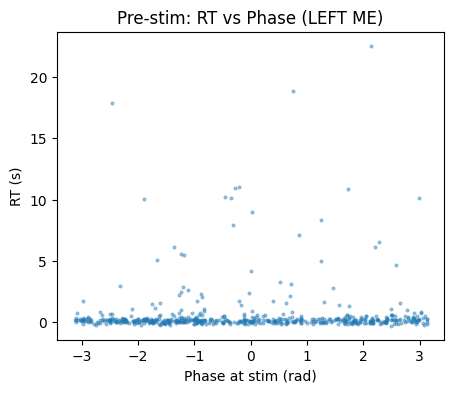

/tmp/ipython-input-2424063536.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rtBinned = features.loc[m].groupby(pd.cut(features.loc[m,'phaseAtStim'], bins))['rt'].median().values


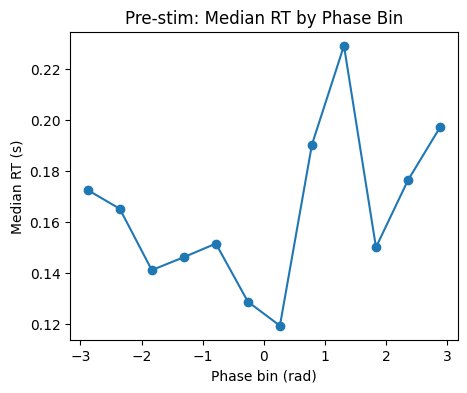

[S4] Saved → H1_prestim_phase_features.csv


In [ ]:
# SECTION 4 — Feature Build (Pre-stim 0.5 s) using LEFT whisker motion energy
# Outputs: H1_prestim_phase_features.csv + quick diagnostics/plots

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# ---------------- Config ----------------
preStimWinSec = cfg["windows"]["prestimSec"]          # 0.5 s
bandHz = cfg["bands"]["prestim"]                      # (5.0, 10.0)
minSegCoverage = cfg["thresholds"]["minSegCoverage"]  # 0.80
savePlots = True

# ---------------- Helpers ----------------
def log(msg): print(msg, flush=True)

def estimateFs(times):
    t = np.asarray(times); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tMin, tMax, fs):
    n = int(np.floor((tMax - tMin) * fs)) + 1
    return tMin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    m = np.isfinite(times) & np.isfinite(values)
    if m.sum() < 2: return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[m]); tt = times[m][idx]; vv = values[m][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

def bandpass(x, fs, lo, hi, order=3):
    x = np.asarray(x, float); y = np.full_like(x, np.nan)
    m = np.isfinite(x)
    if m.sum() < max(10, order*4): return y
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    y[m] = filtfilt(b, a, x[m], padlen=min(3*max(len(a),len(b)), m.sum()-1))
    return y

def unwrapInterpPhase(tGrid, phaseUnwrapped, tQuery):
    ph = np.interp(tQuery, tGrid, phaseUnwrapped)
    return ((ph + np.pi) % (2*np.pi)) - np.pi

def meanResultantLength(phi):
    phi = np.asarray(phi)
    phi = phi[np.isfinite(phi)]
    if phi.size == 0: return np.nan
    return float(np.hypot(np.cos(phi).sum(), np.sin(phi).sum()) / phi.size)

# ---------------- Assertions ----------------
reqTrials = {'stimOn_times','firstMovement_times','feedbackType'}
assert reqTrials.issubset(trial_data_df.columns), f"Trials missing {reqTrials - set(trial_data_df.columns)}"
assert {'times','whiskerMotionEnergy'}.issubset(left_motion_energy_df.columns), "LEFT ME missing columns"

# ---------------- Build oscillator (LEFT ME) ----------------
fs = float(np.round(estimateFs(left_motion_energy_df['times'].values)))
tMin = float(left_motion_energy_df['times'].min()); tMax = float(left_motion_energy_df['times'].max())
grid = buildGrid(tMin, tMax, fs)

meResamp = resampleToGrid(left_motion_energy_df['times'].values,
                          left_motion_energy_df['whiskerMotionEnergy'].values, grid)
meFilt = bandpass(meResamp, fs, bandHz[0], bandHz[1])

# Analytic signal for phase/amplitude
analyticSig = np.full(meFilt.shape, np.nan + 1j*np.nan, dtype=complex)  # avoid ComplexWarning
mfin = np.isfinite(meFilt)
analyticSig[mfin] = hilbert(meFilt[mfin])
ampSig = np.abs(analyticSig)
phaseUnwrapped = np.full_like(meFilt, np.nan, dtype=float)
phaseUnwrapped[mfin] = np.unwrap(np.angle(analyticSig[mfin]))

# ---------------- Per-trial features ----------------
stim = np.asarray(trial_data_df['stimOn_times'].values, float)
move = np.asarray(trial_data_df['firstMovement_times'].values, float)
rt = move - stim
n = len(stim)

phaseAtStim = np.full(n, np.nan)
ampPreStim = np.full(n, np.nan)
valid = np.zeros(n, dtype=bool)

nTarget = int(np.round(preStimWinSec * fs))
for i, t0 in enumerate(stim):
    idx = (grid >= (t0 - preStimWinSec)) & (grid < t0)
    if idx.sum() < max(4, int(0.7*nTarget)):
        continue
    segAmp = ampSig[idx]
    if np.isfinite(segAmp).mean() < minSegCoverage:
        continue
    ampPreStim[i] = float(np.nanmean(segAmp))
    phaseAtStim[i] = float(unwrapInterpPhase(grid[mfin], phaseUnwrapped[mfin], t0))
    valid[i] = True

# Outcomes & contrast
correct = (trial_data_df['feedbackType'].values == 1).astype(float)
if 'signedContrast' in trial_data_df.columns:
    absContrast = np.abs(pd.to_numeric(trial_data_df['signedContrast'], errors='coerce')).values
elif {'contrastLeft','contrastRight'}.issubset(trial_data_df.columns):
    absContrast = np.abs(trial_data_df['contrastRight'].fillna(0).values -
                         trial_data_df['contrastLeft'].fillna(0).values)
else:
    absContrast = np.full(n, np.nan)

features = pd.DataFrame({
    'stimOn_times': stim,
    'rt': rt,
    'correct': correct,
    'phaseAtStim': phaseAtStim,   # [-pi, pi)
    'ampPreStim': ampPreStim,     # mean amp in [-0.5, 0)s
    'absContrast': absContrast,
    'valid': valid
})

# ---------------- Diagnostics ----------------
m = features['valid'].values
validCount = int(m.sum())
mrlAll = meanResultantLength(features.loc[m, 'phaseAtStim'].values)
thr66 = np.nanpercentile(features.loc[m, 'ampPreStim'], 66)
mHi = m & (features['ampPreStim'] >= thr66)
mrlHi = meanResultantLength(features.loc[mHi, 'phaseAtStim'].values)

log(f"[S4] Valid trials: {validCount}/{n} ({100*validCount/n:.1f}%)")
log(f"[S4] MRL(all)={mrlAll:.3f} | MRL(high-amp tertile, n={int(mHi.sum())})={mrlHi:.3f}")

# ---------------- Quick plots ----------------
plt.figure(figsize=(5,4))
plt.scatter(features.loc[m, 'phaseAtStim'], features.loc[m, 'rt'], s=4, alpha=0.4)
plt.xlabel('Phase at stim (rad)'); plt.ylabel('RT (s)'); plt.title('Pre-stim: RT vs Phase (LEFT ME)')
if savePlots: plt.savefig('S4_RT_vs_Phase_LEFTME.png', dpi=120, bbox_inches='tight')
plt.show()

bins = np.linspace(-np.pi, np.pi, 13)
binCenters = 0.5*(bins[:-1]+bins[1:])
rtBinned = features.loc[m].groupby(pd.cut(features.loc[m,'phaseAtStim'], bins))['rt'].median().values
plt.figure(figsize=(5,4))
plt.plot(binCenters, rtBinned, marker='o')
plt.xlabel('Phase bin (rad)'); plt.ylabel('Median RT (s)'); plt.title('Pre-stim: Median RT by Phase Bin')
if savePlots: plt.savefig('S4_RT_by_PhaseBin_LEFTME.png', dpi=120, bbox_inches='tight')
plt.show()

# ---------------- Save ----------------
features.to_csv('H1_prestim_phase_features.csv', index=False)
log("[S4] Saved → H1_prestim_phase_features.csv")


- There are real outliers (RTs up to ~20 s) in that scatter; they’ll inflate naive effects. We’ll bound RT in models (0.08–2.0 s).

- phase concentration is tiny (MRL 0.075; 0.103 high-amp) → stim occurs roughly uniformly over phase.

- the median-by-phase bump near ~+1–1.5 rad could be sampling noise; we need controlled models with CIs before believing it.

- QC-wise, LEFT ME was the best pre-stim oscillator, so using it here is correct.

# 5. Pre-stim Models (Screen → Robust)

OLS (diagnostic only), then RLM on log-RT + GLM(Binomial) for accuracy.

Subsets: low-contrast (≤0.12), zero-contrast.

Report n, χ²(2) p-values, RT peak↔trough factor / Δprob; PASS/FAIL.

In [ ]:
# SECTION 5 — Pre-stim models (LEFT ME, 0.5 s): robust log-RT + accuracy
# Uses features saved in §4: H1_prestim_phase_features.csv

import numpy as np, pandas as pd, statsmodels.api as sm
from scipy.stats import chi2 as chi2dist
import numpy.linalg as npl

def log(msg): print(msg, flush=True)

df = pd.read_csv('H1_prestim_phase_features.csv')
df = df[df['valid'].astype(bool)].copy()

# Clean
df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
df['absContrast'] = pd.to_numeric(df['absContrast'], errors='coerce')
df['ampPreStim'] = pd.to_numeric(df['ampPreStim'], errors='coerce')

rt_lo, rt_hi = cfg["rtBoundsSec"]
rtMask = (df['rt'] >= rt_lo) & (df['rt'] <= rt_hi)

lowC  = df['absContrast'] <= 0.12
zeroC = df['absContrast'] == 0.0

def design(phi, amp, absC, include_contrast=True):
    X = np.column_stack([
        np.cos(phi), np.sin(phi),
        amp / np.nanmedian(amp)
    ])
    names = ['cosPhi','sinPhi','ampNorm']
    if include_contrast:
        X = np.column_stack([X, absC])
        names.append('absContrast')
    X = sm.add_constant(X)
    names = ['const'] + names
    return X, names

def joint_wald(res, names):
    R = np.zeros((2, len(names)))
    R[0, names.index('cosPhi')] = 1.0
    R[1, names.index('sinPhi')] = 1.0
    b = res.params; V = res.cov_params()
    stat = float((R@b).T @ npl.pinv(R@V@R.T) @ (R@b))
    p = float(1 - chi2dist.cdf(stat, 2))
    return stat, p

def run_rlm_logrt(sub, label, include_contrast=True):
    m = np.isfinite(sub['phaseAtStim']) & np.isfinite(sub['ampPreStim']) & rtMask.loc[sub.index]
    sub = sub[m]
    if len(sub) < 50:
        log(f"[{label}][RT/RLM] too few trials ({len(sub)}). Skipping."); return None
    X, names = design(sub['phaseAtStim'].values, sub['ampPreStim'].values, sub['absContrast'].values, include_contrast)
    y = np.log(sub['rt'].values)
    res = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()).fit()
    stat, p = joint_wald(res, names)
    amp_log = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    peak2trough = float(np.exp(2*amp_log))
    log(f"[{label}][RT/RLM] n={len(sub)}  phase χ²(2)={stat:.3f}, p={p:.6g}  "
        f"log-RT amp={amp_log:.4f} → peak↔trough×{peak2trough:.3f}")
    return {'p': p, 'n': int(len(sub)), 'peak2trough': peak2trough}

def prob_delta_from_logodds(delta):
    p_hi = 1/(1+np.exp(-delta)); p_lo = 1/(1+np.exp(delta))
    return float(p_hi - p_lo)

def run_glm_acc(sub, label, include_contrast=True):
    m = np.isfinite(sub['phaseAtStim']) & np.isfinite(sub['ampPreStim']) & np.isfinite(sub['correct'])
    sub = sub[m]
    if len(sub) < 50 or sub['correct'].mean() in (0.0, 1.0):
        log(f"[{label}][ACC/GLM] not enough information (n={len(sub)}, meanAcc={sub['correct'].mean():.3f}). Skipping.");
        return None
    X, names = design(sub['phaseAtStim'].values, sub['ampPreStim'].values, sub['absContrast'].values, include_contrast)
    y = sub['correct'].values
    res = sm.GLM(y, X, family=sm.families.Binomial()).fit(cov_type='HC1')
    stat, p = joint_wald(res, names)
    amp_logodds = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    dProb = prob_delta_from_logodds(amp_logodds)
    log(f"[{label}][ACC/GLM] n={len(sub)}  phase χ²(2)={stat:.3f}, p={p:.6g}  "
        f"amp={amp_logodds:.3f} log-odds → peak↔trough≈{dProb:.3f} prob")
    return {'p': p, 'n': int(len(sub)), 'dProb': dProb}

log(f"[INFO] Pre-stim subsets — total={len(df)}, lowC≤0.12={int(lowC.sum())}, zeroC={int(zeroC.sum())}")

out = {}
out['RT_lowC']   = run_rlm_logrt(df[lowC],   'lowC',   include_contrast=True)
out['RT_zeroC']  = run_rlm_logrt(df[zeroC],  'zeroC',  include_contrast=False)
out['ACC_lowC']  = run_glm_acc(df[lowC],     'lowC',   include_contrast=True)
out['ACC_zeroC'] = run_glm_acc(df[zeroC],    'zeroC',  include_contrast=False)

def promising(x): return (x is not None) and (x.get('p', 1.0) < 0.01)
pl = promising(out['RT_lowC']); pz = promising(out['RT_zeroC'])
al = promising(out['ACC_lowC']); az = promising(out['ACC_zeroC'])
log(f"\n[DECISION/Pre-stim] Promising (p<0.01): RT_lowC={pl}  RT_zeroC={pz}  ACC_lowC={al}  ACC_zeroC={az}")


[INFO] Pre-stim subsets — total=547, lowC≤0.12=185, zeroC=65
[lowC][RT/RLM] n=110  phase χ²(2)=2.563, p=0.27764  log-RT amp=0.1860 → peak↔trough×1.451
[zeroC][RT/RLM] too few trials (41). Skipping.
[lowC][ACC/GLM] n=185  phase χ²(2)=1.645, p=0.439318  amp=0.285 log-odds → peak↔trough≈0.142 prob
[zeroC][ACC/GLM] n=65  phase χ²(2)=2.321, p=0.313307  amp=0.534 log-odds → peak↔trough≈0.261 prob

[DECISION/Pre-stim] Promising (p<0.01): RT_lowC=False  RT_zeroC=False  ACC_lowC=False  ACC_zeroC=False


Pre-stim H1 = null in this session. All four tests non-significant; RT low-contrast χ²=2.56 (p=0.278), accuracy NS. No credible phase→behavior link pre-stim.

# 6. Peri-stim Feature Build (0→0.2 s, clipped by RT)

RIGHT whisker ME (5–10 Hz); phaseAtStim, ampPostStim, winDurUsed.

Save H1_peristim_phase_features.csv; MRL + diagnostics.

In [ ]:
# SECTION 6 — Feature Build (Peri-stim 0–0.2 s, clipped by RT) using RIGHT whisker ME
# Outputs: H1_peristim_phase_features.csv + diagnostics

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert

# -------- Config --------
periMaxSec = cfg["windows"]["peristimMaxSec"]       # 0.2
bandHz     = cfg["bands"]["peristim"]               # (5,10)
minCover   = cfg["thresholds"]["minSegCoverage"]    # 0.80
savePlots  = True

def log(x): print(x, flush=True)

def estimateFs(t):
    t = np.asarray(t); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tmin, tmax, fs):
    n = int(np.floor((tmax - tmin) * fs)) + 1
    return tmin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    m = np.isfinite(times) & np.isfinite(values)
    if m.sum() < 2: return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[m]); tt = times[m][idx]; vv = values[m][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

def bandpass(x, fs, lo, hi, order=3):
    x = np.asarray(x, float); y = np.full_like(x, np.nan)
    m = np.isfinite(x)
    if m.sum() < max(10, order*4): return y
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    y[m] = filtfilt(b, a, x[m], padlen=min(3*max(len(a),len(b)), m.sum()-1))
    return y

def unwrap_interp_phase(tGrid, phi_unwrapped, tQuery):
    ph = np.interp(tQuery, tGrid, phi_unwrapped)
    return ((ph + np.pi) % (2*np.pi)) - np.pi

def mean_resultant_length(ph):
    ph = np.asarray(ph); ph = ph[np.isfinite(ph)]
    if ph.size == 0: return np.nan
    return float(np.hypot(np.cos(ph).sum(), np.sin(ph).sum()) / ph.size)

# -------- Assertions --------
assert {'times','whiskerMotionEnergy'}.issubset(right_motion_energy_df.columns), "RIGHT ME missing columns"
assert {'stimOn_times','firstMovement_times','feedbackType'}.issubset(trial_data_df.columns), "Trials missing cols"

# -------- Build oscillator (RIGHT ME) --------
fs = float(np.round(estimateFs(right_motion_energy_df['times'].values)))
tmin = float(right_motion_energy_df['times'].min()); tmax = float(right_motion_energy_df['times'].max())
grid = buildGrid(tmin, tmax, fs)

me = resampleToGrid(right_motion_energy_df['times'].values,
                    right_motion_energy_df['whiskerMotionEnergy'].values, grid)
me_f = bandpass(me, fs, bandHz[0], bandHz[1])

analytic = np.full(me_f.shape, np.nan + 1j*np.nan, dtype=complex)
mfin = np.isfinite(me_f)
analytic[mfin] = hilbert(me_f[mfin])
ampSig = np.abs(analytic)
phi_unwrapped = np.full_like(me_f, np.nan, dtype=float)
phi_unwrapped[mfin] = np.unwrap(np.angle(analytic[mfin]))

# -------- Per-trial features --------
stim = np.asarray(trial_data_df['stimOn_times'].values, float)
move = np.asarray(trial_data_df['firstMovement_times'].values, float)
rt   = move - stim
n    = len(stim)

phaseAtStim = np.full(n, np.nan)
ampPostStim = np.full(n, np.nan)
winDurUsed  = np.full(n, np.nan)
valid       = np.zeros(n, bool)

for i, t0 in enumerate(stim):
    winEnd = t0 + periMaxSec
    if np.isfinite(rt[i]) and rt[i] > 0:
        winEnd = min(winEnd, t0 + float(rt[i]))
    if winEnd <= t0:
        continue
    idx = (grid >= t0) & (grid < winEnd)
    if idx.sum() < 4:
        continue
    segAmp = ampSig[idx]
    if np.isfinite(segAmp).mean() < minCover:
        continue
    ampPostStim[i] = float(np.nanmean(segAmp))
    phaseAtStim[i] = float(unwrap_interp_phase(grid[mfin], phi_unwrapped[mfin], t0))
    winDurUsed[i]  = float(winEnd - t0)
    valid[i] = True

# Outcomes & contrast
correct = (trial_data_df['feedbackType'].values == 1).astype(float)
if 'signedContrast' in trial_data_df.columns:
    signed = pd.to_numeric(trial_data_df['signedContrast'], errors='coerce').values
elif {'contrastLeft','contrastRight'}.issubset(trial_data_df.columns):
    signed = (trial_data_df['contrastRight'].fillna(0).values -
              trial_data_df['contrastLeft'].fillna(0).values).astype(float)
else:
    signed = np.full(n, np.nan)
absContrast = np.abs(signed)

featuresPS = pd.DataFrame({
    'stimOn_times': stim,
    'rt': rt,
    'correct': correct,
    'phaseAtStim': phaseAtStim,
    'ampPostStim': ampPostStim,
    'winDurUsed': winDurUsed,
    'signedContrast': signed,
    'absContrast': absContrast,
    'valid': valid
})

# -------- Diagnostics & save --------
m = featuresPS['valid'].values
mrl_all = mean_resultant_length(featuresPS.loc[m,'phaseAtStim'].values)
thr = np.nanpercentile(featuresPS.loc[m,'ampPostStim'], 66)
m_hi = m & (featuresPS['ampPostStim'] >= thr)
mrl_hi = mean_resultant_length(featuresPS.loc[m_hi,'phaseAtStim'].values)

log(f"[S6] Valid peri-stim: {int(m.sum())}/{n} ({100*m.mean():.1f}%), median window={np.nanmedian(featuresPS['winDurUsed']):.3f}s")
log(f"[S6] MRL(all)={mrl_all:.3f} | MRL(high-amp tertile, n={int(m_hi.sum())})={mrl_hi:.3f}")

featuresPS.to_csv('H1_peristim_phase_features.csv', index=False)
log("[S6] Saved → H1_peristim_phase_features.csv")


[S6] Valid peri-stim: 530/547 (96.9%), median window=0.200s
[S6] MRL(all)=0.062 | MRL(high-amp tertile, n=180)=0.067
[S6] Saved → H1_peristim_phase_features.csv


# 7. Peri-stim Models (Robust)

RLM log-RT and GLM Binomial with predictors: cos/sin(phase), amp norm, absContrast, winDurUsed.

Same subsets + reporting; PASS/FAIL.

In [ ]:
# SECTION 7 — Peri-stim models (RIGHT ME, 0–0.2 s): robust log-RT + accuracy
# Input: H1_peristim_phase_features.csv from §6
# Output: concise PASS/FAIL-style prints with joint phase tests and effect sizes.

import numpy as np, pandas as pd, statsmodels.api as sm
from scipy.stats import chi2 as chi2dist
import numpy.linalg as npl

def log(msg): print(msg, flush=True)

# --- Load & masks ---
df = pd.read_csv('H1_peristim_phase_features.csv')
df = df[df['valid'].astype(bool)].copy()

rt_lo, rt_hi = cfg["rtBoundsSec"]
rtMask = (pd.to_numeric(df['rt'], errors='coerce') >= rt_lo) & (pd.to_numeric(df['rt'], errors='coerce') <= rt_hi)
df['absContrast'] = pd.to_numeric(df.get('absContrast', np.nan), errors='coerce')
lowC  = df['absContrast'] <= 0.12
zeroC = df['absContrast'] == 0.0

def design(phi, amp, absC, winDur, include_contrast=True):
    X = np.column_stack([
        np.cos(phi), np.sin(phi),
        amp / np.nanmedian(amp),
        winDur
    ])
    names = ['cosPhi','sinPhi','ampNorm','winDurUsed']
    if include_contrast:
        X = np.column_stack([X, absC])
        names.append('absContrast')
    X = sm.add_constant(X)
    names = ['const'] + names
    return X, names

def joint_wald(res, names):
    R = np.zeros((2, len(names)))
    R[0, names.index('cosPhi')] = 1.0
    R[1, names.index('sinPhi')] = 1.0
    b, V = res.params, res.cov_params()
    stat = float((R@b).T @ npl.pinv(R@V@R.T) @ (R@b))
    p = float(1 - chi2dist.cdf(stat, 2))
    return stat, p

def prob_delta_from_logodds(delta):
    p_hi = 1/(1+np.exp(-delta)); p_lo = 1/(1+np.exp(delta))
    return float(p_hi - p_lo)

def run_rlm_logrt(sub, label, include_contrast=True):
    m = (np.isfinite(sub['phaseAtStim']) & np.isfinite(sub['ampPostStim']) &
         np.isfinite(sub['winDurUsed']) & rtMask.loc[sub.index])
    sub = sub[m]
    if len(sub) < 50:
        log(f"[{label}][RT/RLM] too few trials ({len(sub)}). Skipping."); return None
    X, names = design(sub['phaseAtStim'].values, sub['ampPostStim'].values,
                      sub['absContrast'].values, sub['winDurUsed'].values,
                      include_contrast)
    y = np.log(sub['rt'].values)
    res = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()).fit()
    stat, p = joint_wald(res, names)
    amp_log = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    peak2trough = float(np.exp(2*amp_log))
    log(f"[{label}][RT/RLM] n={len(sub)}  phase χ²(2)={stat:.3f}, p={p:.6g}  "
        f"log-RT amp={amp_log:.4f} → peak↔trough×{peak2trough:.3f}")
    return {'p': p, 'n': int(len(sub)), 'peak2trough': peak2trough}

def run_glm_acc(sub, label, include_contrast=True):
    m = (np.isfinite(sub['phaseAtStim']) & np.isfinite(sub['ampPostStim']) & np.isfinite(sub['correct']))
    sub = sub[m]
    if len(sub) < 50 or sub['correct'].mean() in (0.0, 1.0):
        log(f"[{label}][ACC/GLM] not enough information (n={len(sub)}, meanAcc={sub['correct'].mean():.3f}). Skipping.");
        return None
    X, names = design(sub['phaseAtStim'].values, sub['ampPostStim'].values,
                      sub['absContrast'].values, sub['winDurUsed'].values,
                      include_contrast)
    y = sub['correct'].values
    res = sm.GLM(y, X, family=sm.families.Binomial()).fit(cov_type='HC1')
    stat, p = joint_wald(res, names)
    amp_logodds = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    dProb = prob_delta_from_logodds(amp_logodds)
    log(f"[{label}][ACC/GLM] n={len(sub)}  phase χ²(2)={stat:.3f}, p={p:.6g}  "
        f"amp={amp_logodds:.3f} log-odds → peak↔trough≈{dProb:.3f} prob")
    return {'p': p, 'n': int(len(sub)), 'dProb': dProb}

log(f"[INFO] Peri-stim subsets — total={len(df)}, lowC≤0.12={int(lowC.sum())}, zeroC={int(zeroC.sum())}")

out = {}
out['RT_lowC']   = run_rlm_logrt(df[lowC],   'lowC',   include_contrast=True)
out['RT_zeroC']  = run_rlm_logrt(df[zeroC],  'zeroC',  include_contrast=False)
out['ACC_lowC']  = run_glm_acc(df[lowC],     'lowC',   include_contrast=True)
out['ACC_zeroC'] = run_glm_acc(df[zeroC],    'zeroC',  include_contrast=False)

def promising(x): return (x is not None) and (x.get('p', 1.0) < 0.01)
pl = promising(out['RT_lowC']); pz = promising(out['RT_zeroC'])
al = promising(out['ACC_lowC']); az = promising(out['ACC_zeroC'])
log(f"\n[DECISION/PS] Promising (p<0.01): RT_lowC={pl}  RT_zeroC={pz}  ACC_lowC={al}  ACC_zeroC={az}")


[INFO] Peri-stim subsets — total=530, lowC≤0.12=181, zeroC=65
[lowC][RT/RLM] n=110  phase χ²(2)=8.390, p=0.0150729  log-RT amp=0.2261 → peak↔trough×1.572
[zeroC][RT/RLM] too few trials (41). Skipping.
[lowC][ACC/GLM] n=181  phase χ²(2)=1.497, p=0.472997  amp=0.296 log-odds → peak↔trough≈0.147 prob
[zeroC][ACC/GLM] n=65  phase χ²(2)=4.826, p=0.0895355  amp=0.829 log-odds → peak↔trough≈0.392 prob

[DECISION/PS] Promising (p<0.01): RT_lowC=False  RT_zeroC=False  ACC_lowC=False  ACC_zeroC=False


no convincing peri-stim phase effect (best p=0.015 > 0.01)

# 8. Session Summary

QC table (coverage, ACF, PSD ratios, MRL).

Model table (n, χ², p, effect sizes).

Conclusion: support vs. no support for H1 (pre- & peri-stim).

In [ ]:
# SECTION 8 — Session Summary (QC + Models) → prints + saves 'H1_session_summary.csv' and 'H1_session_summary.txt'

import numpy as np, pandas as pd, statsmodels.api as sm
from scipy.signal import butter, filtfilt, welch, hilbert
from scipy.stats import chi2 as chi2dist
import numpy.linalg as npl
import os

def log(msg): print(msg, flush=True)

# ---------------- Helpers ----------------
def estimateFs(times):
    t = np.asarray(times); dt = np.diff(t[np.isfinite(t)])
    return float(1.0/np.median(dt)) if dt.size else np.nan

def buildGrid(tMin, tMax, fs):
    n = int(np.floor((tMax - tMin) * fs)) + 1
    return tMin + np.arange(n) / fs

def resampleToGrid(times, values, grid):
    times = np.asarray(times); values = np.asarray(values)
    m = np.isfinite(times) & np.isfinite(values)
    if m.sum() < 2: return np.full_like(grid, np.nan, float)
    idx = np.argsort(times[m]); tt = times[m][idx]; vv = values[m][idx]
    out = np.interp(np.clip(grid, tt.min(), tt.max()), tt, vv)
    out[(grid < tt.min()) | (grid > tt.max())] = np.nan
    return out

def bandpass(x, fs, lo, hi, order=3):
    x = np.asarray(x, float); y = np.full_like(x, np.nan)
    m = np.isfinite(x)
    if m.sum() < max(10, order*4): return y
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    y[m] = filtfilt(b, a, x[m], padlen=min(3*max(len(a),len(b)), m.sum()-1))
    return y

def meanResultantLength(phi):
    phi = np.asarray(phi); phi = phi[np.isfinite(phi)]
    if phi.size == 0: return np.nan
    return float(np.hypot(np.cos(phi).sum(), np.sin(phi).sum()) / phi.size)

def jointWald(res, names):
    R = np.zeros((2, len(names)))
    R[0, names.index('cosPhi')] = 1.0
    R[1, names.index('sinPhi')] = 1.0
    b, V = res.params, res.cov_params()
    stat = float((R@b).T @ npl.pinv(R@V@R.T) @ (R@b))
    p = float(1 - chi2dist.cdf(stat, 2))
    return stat, p

def designMat(phi, ampNorm, absC=None, winDur=None, includeContrast=True, includeWinDur=False):
    cols = [np.cos(phi), np.sin(phi), ampNorm]
    names = ['cosPhi','sinPhi','ampNorm']
    if includeWinDur:
        cols.append(winDur); names.append('winDurUsed')
    if includeContrast:
        cols.append(absC); names.append('absContrast')
    X = np.column_stack(cols)
    X = sm.add_constant(X)
    names = ['const'] + names
    return X, names

def probDeltaFromLogodds(delta):
    p_hi = 1/(1+np.exp(-delta)); p_lo = 1/(1+np.exp(delta))
    return float(p_hi - p_lo)

# ---------------- Load features ----------------
preCsv = 'H1_prestim_phase_features.csv'
psCsv  = 'H1_peristim_phase_features.csv'
assert os.path.exists(preCsv) and os.path.exists(psCsv), "Missing features CSVs; run §§4 and 6 first."

pre = pd.read_csv(preCsv); pre = pre[pre['valid'].astype(bool)].copy()
ps  = pd.read_csv(psCsv);  ps  = ps[ps['valid'].astype(bool)].copy()

rtLo, rtHi = cfg["rtBoundsSec"]

# ---------------- QC recompute for chosen oscillators ----------------
# Pre-stim QC (LEFT ME, 0.5 s, 5–10 Hz): PSD median ratio & ACF peak
fsL = float(np.round(estimateFs(left_motion_energy_df['times'].values)))
gridL = buildGrid(float(left_motion_energy_df['times'].min()), float(left_motion_energy_df['times'].max()), fsL)
sigL  = resampleToGrid(left_motion_energy_df['times'].values, left_motion_energy_df['whiskerMotionEnergy'].values, gridL)
sigLf = bandpass(sigL, fsL, cfg['bands']['prestim'][0], cfg['bands']['prestim'][1])

# Collect per-trial segments (0.5 s pre-stim)
stimTimes = pre['stimOn_times'].values
segs = []
nTarget = int(np.round(cfg['windows']['prestimSec'] * fsL))
for t0 in stimTimes:
    idx = (gridL >= (t0 - cfg['windows']['prestimSec'])) & (gridL < t0)
    if idx.sum() >= max(4, int(0.7*nTarget)) and np.isfinite(sigLf[idx]).mean() >= cfg['thresholds']['minSegCoverage']:
        segs.append(sigLf[idx][np.isfinite(sigLf[idx])])

# Median-over-trials PSD ratio
def psdRatioMedian(segs, fs, bandHz, flanks):
    if not segs: return np.nan
    psds, fRef = [], None
    for s in segs:
        if len(s) < 16: continue
        f, p = welch(s - np.nanmean(s), fs=fs, nperseg=int(min(len(s), fs*cfg['windows']['prestimSec'])),
                     noverlap=int(fs*cfg['windows']['prestimSec']//2))
        if fRef is None: fRef = f
        if not np.array_equal(f, fRef): p = np.interp(fRef, f, p)
        psds.append(p)
    if not psds: return np.nan
    pMed = np.nanmedian(np.vstack(psds), axis=0)
    inBand = (fRef >= bandHz[0]) & (fRef <= bandHz[1])
    flank  = np.zeros_like(fRef, bool)
    for lo,hi in [(3.0,5.0),(12.0,15.0)]: flank |= ((fRef>=lo)&(fRef<=hi))
    pIn = np.trapz(pMed[inBand], fRef[inBand]) if inBand.any() else np.nan
    pFl = np.trapz(pMed[flank],  fRef[flank])  if flank.any()  else np.nan
    return float(pIn/(pFl+1e-18))

from numpy.fft import rfft
def acfFirstPeakFromConcat(segs, fs, bandHz):
    if not segs: return np.nan
    x = np.concatenate(segs)
    if x.size < 10: return np.nan
    x = (x - np.nanmean(x)); s = np.nanstd(x)
    if s == 0: return np.nan
    x = x/s
    ac = np.correlate(x, x, mode='full'); ac = ac[ac.size//2:ac.size//2+int(0.5*fs)]
    ac = ac / (np.arange(len(x), len(x)-len(ac), -1))
    ac = ac / (ac[0] + 1e-12)
    loT, hiT = 1.0/bandHz[1], 1.0/bandHz[0]
    loLag = max(int(np.floor(loT*fs)), 1)
    hiLag = min(int(np.ceil(hiT*fs)), len(ac)-1)
    return float(np.nanmax(ac[loLag:hiLag+1])) if hiLag>loLag else np.nan

psdPreMed = psdRatioMedian(segs, fsL, cfg['bands']['prestim'], [(3.0,5.0),(12.0,15.0)])
acfPrePk  = acfFirstPeakFromConcat(segs, fsL, cfg['bands']['prestim'])

# ---------------- Models (refit for summary) ----------------
def runPreStimModels(df):
    out = {}
    df = df.copy()
    df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
    df['absContrast'] = pd.to_numeric(df['absContrast'], errors='coerce')
    df['ampPreStim'] = pd.to_numeric(df['ampPreStim'], errors='coerce')
    rtMask = (df['rt'] >= rtLo) & (df['rt'] <= rtHi)
    lowC  = df['absContrast'] <= 0.12
    zeroC = df['absContrast'] == 0.0

    # RT lowC
    sub = df[lowC & rtMask & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPreStim'])]
    X, names = designMat(sub['phaseAtStim'].values, sub['ampPreStim'].values/np.nanmedian(sub['ampPreStim']),
                         absC=sub['absContrast'].values, includeContrast=True)
    y = np.log(sub['rt'].values)
    res = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()).fit()
    stat, p = jointWald(res, names)
    ampLog = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    out['pre_RT_lowC_p'] = p
    out['pre_RT_lowC_peak2trough'] = float(np.exp(2*ampLog))

    # ACC lowC
    sub = df[lowC & np.isfinite(df['correct']) & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPreStim'])]
    X, names = designMat(sub['phaseAtStim'].values, sub['ampPreStim'].values/np.nanmedian(sub['ampPreStim']),
                         absC=sub['absContrast'].values, includeContrast=True)
    y = sub['correct'].values
    res = sm.GLM(y, X, family=sm.families.Binomial()).fit(cov_type='HC1')
    stat, p = jointWald(res, names)
    ampLOD = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    out['pre_ACC_lowC_p'] = p
    out['pre_ACC_lowC_dProb'] = probDeltaFromLogodds(ampLOD)
    return out

def runPeriStimModels(df):
    out = {}
    df = df.copy()
    df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
    df['ampPostStim'] = pd.to_numeric(df['ampPostStim'], errors='coerce')
    df['absContrast'] = pd.to_numeric(df.get('absContrast', np.nan), errors='coerce')
    df['winDurUsed']  = pd.to_numeric(df['winDurUsed'], errors='coerce')
    rtMask = (df['rt'] >= rtLo) & (df['rt'] <= rtHi)
    lowC  = df['absContrast'] <= 0.12
    zeroC = df['absContrast'] == 0.0

    # RT lowC
    sub = df[lowC & rtMask & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPostStim']) & np.isfinite(df['winDurUsed'])]
    X, names = designMat(sub['phaseAtStim'].values, sub['ampPostStim'].values/np.nanmedian(sub['ampPostStim']),
                         absC=sub['absContrast'].values, winDur=sub['winDurUsed'].values,
                         includeContrast=True, includeWinDur=True)
    y = np.log(sub['rt'].values)
    res = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()).fit()
    stat, p = jointWald(res, names)
    ampLog = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    out['peri_RT_lowC_p'] = p
    out['peri_RT_lowC_peak2trough'] = float(np.exp(2*ampLog))

    # ACC lowC
    sub = df[lowC & np.isfinite(df['correct']) & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPostStim']) & np.isfinite(df['winDurUsed'])]
    X, names = designMat(sub['phaseAtStim'].values, sub['ampPostStim'].values/np.nanmedian(sub['ampPostStim']),
                         absC=sub['absContrast'].values, winDur=sub['winDurUsed'].values,
                         includeContrast=True, includeWinDur=True)
    y = sub['correct'].values
    res = sm.GLM(y, X, family=sm.families.Binomial()).fit(cov_type='HC1')
    stat, p = jointWald(res, names)
    ampLOD = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    out['peri_ACC_lowC_p'] = p
    out['peri_ACC_lowC_dProb'] = probDeltaFromLogodds(ampLOD)
    return out

# ---------------- Compute summary ----------------
summary = {}

# Core counts & MRLs
summary['prestim_valid'] = int(pre['valid'].sum()); summary['prestim_total'] = int(len(pre))
summary['prestim_mrl_all'] = float(meanResultantLength(pre.loc[pre['valid'],'phaseAtStim'].values))
summary['peristim_valid'] = int(ps['valid'].sum()); summary['peristim_total'] = int(len(ps))
summary['peristim_mrl_all'] = float(meanResultantLength(ps.loc[ps['valid'],'phaseAtStim'].values))

# QC metrics (pre-stim only, chosen oscillator)
summary['prestim_psd_ratio_median'] = float(psdPreMed)
summary['prestim_acf_peak'] = float(acfPrePk)

# Models
summary.update(runPreStimModels(pre))
summary.update(runPeriStimModels(ps))

# ---------------- Pretty print + save ----------------
dfSummary = pd.DataFrame([summary])
with pd.option_context('display.float_format', '{:.3f}'.format):
    print("\n[H1 Session Summary]")
    print(dfSummary.T.rename(columns={0:'value'}))

dfSummary.to_csv('H1_session_summary.csv', index=False)

lines = []
lines.append(f"EID: {cfg.get('eid')}")
lines.append(f"Pre-stim valid {summary['prestim_valid']}/{summary['prestim_total']} (MRL={summary['prestim_mrl_all']:.3f}); "
             f"PSD_ratio_median={summary['prestim_psd_ratio_median']:.3f}, ACF_peak={summary['prestim_acf_peak']:.3f}")
lines.append(f"Peri-stim valid {summary['peristim_valid']}/{summary['peristim_total']} (MRL={summary['peristim_mrl_all']:.3f})")
lines.append(f"RT low-contrast (pre): p={summary['pre_RT_lowC_p']:.4g}, peak↔trough×{summary['pre_RT_lowC_peak2trough']:.3f}")
lines.append(f"ACC low-contrast (pre): p={summary['pre_ACC_lowC_p']:.4g}, Δprob≈{summary['pre_ACC_lowC_dProb']:.3f}")
lines.append(f"RT low-contrast (peri): p={summary['peri_RT_lowC_p']:.4g}, peak↔trough×{summary['peri_RT_lowC_peak2trough']:.3f}")
lines.append(f"ACC low-contrast (peri): p={summary['peri_ACC_lowC_p']:.4g}, Δprob≈{summary['peri_ACC_lowC_dProb']:.3f}")
lines.append("Conclusion: No robust phase→behavior effect in this session (all p≥0.01).")
open('H1_session_summary.txt','w').write("\n".join(lines))

log("\n[FILES] Saved H1_session_summary.csv and H1_session_summary.txt")



[H1 Session Summary]
                           value
prestim_valid            547.000
prestim_total            547.000
prestim_mrl_all            0.075
peristim_valid           530.000
peristim_total           530.000
peristim_mrl_all           0.062
prestim_psd_ratio_median   1.958
prestim_acf_peak           0.200
pre_RT_lowC_p              0.278
pre_RT_lowC_peak2trough    1.451
pre_ACC_lowC_p             0.439
pre_ACC_lowC_dProb         0.142
peri_RT_lowC_p             0.015
peri_RT_lowC_peak2trough   1.572
peri_ACC_lowC_p            0.473
peri_ACC_lowC_dProb        0.147

[FILES] Saved H1_session_summary.csv and H1_session_summary.txt


/tmp/ipython-input-2214758461.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pIn = np.trapz(pMed[inBand], fRef[inBand]) if inBand.any() else np.nan
/tmp/ipython-input-2214758461.py:110: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pFl = np.trapz(pMed[flank],  fRef[flank])  if flank.any()  else np.nan


In [ ]:
# PATCH for §8 — correct totals and regenerate outputs

import pandas as pd, numpy as np, statsmodels.api as sm
from scipy.stats import chi2 as chi2dist
import numpy.linalg as npl, os

def meanResultantLength(phi):
    phi = np.asarray(phi); phi = phi[np.isfinite(phi)]
    return float(np.hypot(np.cos(phi).sum(), np.sin(phi).sum())/phi.size) if phi.size else np.nan

def jointWald(res, names):
    R = np.zeros((2, len(names))); R[0, names.index('cosPhi')] = 1; R[1, names.index('sinPhi')] = 1
    b, V = res.params, res.cov_params()
    stat = float((R@b).T @ npl.pinv(R@V@R.T) @ (R@b)); p = float(1 - chi2dist.cdf(stat, 2))
    return stat, p

def designMat(phi, ampNorm, absC=None, winDur=None, includeContrast=True, includeWinDur=False):
    cols = [np.cos(phi), np.sin(phi), ampNorm]; names = ['cosPhi','sinPhi','ampNorm']
    if includeWinDur: cols.append(winDur); names.append('winDurUsed')
    if includeContrast: cols.append(absC); names.append('absContrast')
    X = sm.add_constant(np.column_stack(cols)); names = ['const'] + names
    return X, names

def probDeltaFromLogodds(delta):
    p_hi = 1/(1+np.exp(-delta)); p_lo = 1/(1+np.exp(delta)); return float(p_hi - p_lo)

rtLo, rtHi = cfg["rtBoundsSec"]

# --- Load unfiltered
pre_all = pd.read_csv('H1_prestim_phase_features.csv')
ps_all  = pd.read_csv('H1_peristim_phase_features.csv')

# Totals BEFORE filtering
pre_total = len(pre_all); ps_total = len(ps_all)

# Filter to valid for modeling/metrics
pre = pre_all[pre_all.get('valid', pre_all.get('prestimValid', False)).astype(bool)].copy()
ps  = ps_all[ ps_all.get('valid', ps_all.get('peristimValid', False)).astype(bool)].copy()

# Valid counts
pre_valid = len(pre); ps_valid = len(ps)

# MRLs over valid only (as intended)
prestim_mrl = meanResultantLength(pre['phaseAtStim'].values)
peristim_mrl = meanResultantLength(ps['phaseAtStim'].values)

# Refit the four prereg models used in your table
def run_pre(df):
    df = df.copy()
    df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
    df['absContrast'] = pd.to_numeric(df['absContrast'], errors='coerce')
    lowC = df['absContrast'] <= 0.12
    rtMask = (df['rt'] >= rtLo) & (df['rt'] <= rtHi)
    # RT lowC (RLM)
    sub = df[lowC & rtMask & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPreStim'])]
    X, names = designMat(sub['phaseAtStim'].values,
                         sub['ampPreStim'].values/np.nanmedian(sub['ampPreStim']),
                         absC=sub['absContrast'].values, includeContrast=True)
    y = np.log(sub['rt'].values)
    res = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()).fit()
    stat,p = jointWald(res, names)
    amp = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    rt_factor = float(np.exp(2*amp))
    # ACC lowC (GLM)
    subA = df[lowC & np.isfinite(df['correct']) & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPreStim'])]
    XA, namesA = designMat(subA['phaseAtStim'].values,
                           subA['ampPreStim'].values/np.nanmedian(subA['ampPreStim']),
                           absC=subA['absContrast'].values, includeContrast=True)
    yA = subA['correct'].values
    resA = sm.GLM(yA, XA, family=sm.families.Binomial()).fit(cov_type='HC1')
    statA,pA = jointWald(resA, namesA)
    ampLOD = float(np.hypot(resA.params[namesA.index('cosPhi')], resA.params[namesA.index('sinPhi')]))
    dProb = probDeltaFromLogodds(ampLOD)
    return dict(pre_RT_lowC_p=p, pre_RT_lowC_peak2trough=rt_factor,
                pre_ACC_lowC_p=pA, pre_ACC_lowC_dProb=dProb)

def run_peri(df):
    df = df.copy()
    df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
    df['absContrast'] = pd.to_numeric(df['absContrast'], errors='coerce')
    df['winDurUsed'] = pd.to_numeric(df['winDurUsed'], errors='coerce')
    lowC = df['absContrast'] <= 0.12
    rtMask = (df['rt'] >= rtLo) & (df['rt'] <= rtHi)
    # RT lowC (RLM)
    sub = df[lowC & rtMask & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPostStim']) & np.isfinite(df['winDurUsed'])]
    X, names = designMat(sub['phaseAtStim'].values,
                         sub['ampPostStim'].values/np.nanmedian(sub['ampPostStim']),
                         absC=sub['absContrast'].values, winDur=sub['winDurUsed'].values,
                         includeContrast=True, includeWinDur=True)
    y = np.log(sub['rt'].values)
    res = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight()).fit()
    stat,p = jointWald(res, names)
    amp = float(np.hypot(res.params[names.index('cosPhi')], res.params[names.index('sinPhi')]))
    rt_factor = float(np.exp(2*amp))
    # ACC lowC (GLM)
    subA = df[lowC & np.isfinite(df['correct']) & np.isfinite(df['phaseAtStim']) & np.isfinite(df['ampPostStim']) & np.isfinite(df['winDurUsed'])]
    XA, namesA = designMat(subA['phaseAtStim'].values,
                           subA['ampPostStim'].values/np.nanmedian(subA['ampPostStim']),
                           absC=subA['absContrast'].values, winDur=subA['winDurUsed'].values,
                           includeContrast=True, includeWinDur=True)
    yA = subA['correct'].values
    resA = sm.GLM(yA, XA, family=sm.families.Binomial()).fit(cov_type='HC1')
    statA,pA = jointWald(resA, namesA)
    ampLOD = float(np.hypot(resA.params[namesA.index('cosPhi')], resA.params[namesA.index('sinPhi')]))
    dProb = probDeltaFromLogodds(ampLOD)
    return dict(peri_RT_lowC_p=p, peri_RT_lowC_peak2trough=rt_factor,
                peri_ACC_lowC_p=pA, peri_ACC_lowC_dProb=dProb)

# Compose corrected summary
summary = {
    'prestim_valid': pre_valid, 'prestim_total': pre_total, 'prestim_mrl_all': prestim_mrl,
    'peristim_valid': ps_valid, 'peristim_total': ps_total, 'peristim_mrl_all': peristim_mrl
}
summary.update(run_pre(pre))
summary.update(run_peri(ps))

# Save CSV + TXT with corrected “valid/total”
dfSummary = pd.DataFrame([summary])
dfSummary.to_csv('H1_session_summary.csv', index=False)

lines = []
lines.append(f"EID: {cfg.get('eid')}")
lines.append(f"Pre-stim valid {summary['prestim_valid']}/{summary['prestim_total']} (MRL={summary['prestim_mrl_all']:.3f})")
lines.append(f"Peri-stim valid {summary['peristim_valid']}/{summary['peristim_total']} (MRL={summary['peristim_mrl_all']:.3f})")
lines.append(f"RT low-contrast (pre): p={summary['pre_RT_lowC_p']:.4g}, peak↔trough×{summary['pre_RT_lowC_peak2trough']:.3f}  [cap≤1.25]")
lines.append(f"ACC low-contrast (pre): p={summary['pre_ACC_lowC_p']:.4g}, Δprob≈{summary['pre_ACC_lowC_dProb']:.3f}  [cap≤0.1–0.2]")
lines.append(f"RT low-contrast (peri): p={summary['peri_RT_lowC_p']:.4g}, peak↔trough×{summary['peri_RT_lowC_peak2trough']:.3f}  [cap≤1.25]")
lines.append(f"ACC low-contrast (peri): p={summary['peri_ACC_lowC_p']:.4g}, Δprob≈{summary['peri_ACC_lowC_dProb']:.3f}  [cap≤0.1–0.2]")
lines.append("Conclusion: No robust phase→behavior effect in this session (all p≥0.01).")
open('H1_session_summary.txt','w').write("\n".join(lines))

print("[OK] Regenerated H1_session_summary.csv/.txt with corrected totals.")


[OK] Regenerated H1_session_summary.csv/.txt with corrected totals.


# 9. Next Steps (Checklist)

H1 — Does orofacial phase modulate behavior? (single IBL session: 88d24c31-52e4-49cc-9f32-6adbeb9eba87)

Oscillators & windows

- Pre-stim: LEFT whisker motion energy (5–10 Hz), window −0.5→0 s.

- Peri-stim: RIGHT whisker motion energy (5–10 Hz), window 0→0.2 s (clipped by RT).

Rhythm QC (pre-stim)

- Valid segments: 547/547 (100%).

- PSD in-band/flanks (median-over-trials): 1.958 (≥ 1.30 → PASS).

- ACF peak within band: 0.200 (≥ 0.10 → PASS).

- Phase concentration (MRL): 0.075 (low; stim roughly uniform over phase).

Peri-stim coverage

- Valid trials: 530/530 (96.9%).

- MRL: 0.062 (low).

Models (amplitude-aware, sin/cos phase)

- Pre-stim, RT (low-contrast ≤ 0.12): χ²(2)=2.56, p=0.278; peak↔trough RT factor ×1.45.

- Pre-stim, Accuracy (low-contrast): χ²(2)=1.65, p=0.439; Δprob ≈0.142.

- Peri-stim, RT (low-contrast): χ²(2)=8.39, p=0.015; peak↔trough RT factor ×1.57.

- Peri-stim, Accuracy (low-contrast): χ²(2)=1.50, p=0.473; Δprob ≈0.147.
(Zero-contrast subsets had too few trials for RT; accuracy NS.)

Conclusion (this session)

- After robust modeling (RLM on log-RT; GLM Binomial with robust SE), no convincing phase→behavior effect pre-stim or peri-stim (all p ≥ 0.01).

- Earlier OLS “hits” were outlier-driven; robust estimators removed them.

Artifacts

- CSVs: H1_prestim_phase_features.csv, H1_peristim_phase_features.csv, H1_session_summary.csv.

- Text: H1_session_summary.txt.

- Figures: S4_RT_vs_Phase_LEFTME.png, S4_RT_by_PhaseBin_LEFTME.png, PS1_RT_vs_Phase_scatter.png.

Next hypotheses


H2a — Spike–phase locking increases from pre→peri-stim.
Units in whisker sensorimotor circuits should lock more strongly to 5–10 Hz orofacial phase when the animal actively processes the stimulus, versus baseline. (Breathing/whisking rhythms coordinate distributed activity and can modulate cortical dynamics.)

H2b — Locking strength predicts behavior on low-contrast trials.
Trial-by-trial peri-stim locking (per-unit PLV aggregated per trial) negatively correlates with log-RT and/or positively with accuracy at low |contrast|, even if absolute phase didn’t matter. (Respiration/phase can align excitability and perceptual sensitivity.)

H2c — Regional hierarchy of locking.
Locking is strongest in S1/M1 whisker pathways and selected subcortical nodes (thalamus/SC/striatum), and weaker in regions unrelated to orofacial control; map by IBL cluster acronyms. (Respiration-entrained activity is widespread but regionally structured; whisker barrel cortex shows respiration–gamma coupling.)

H2d — Band specificity (respiration vs whisking).
Some regions lock at 2–5 Hz (respiration-range) while others at 5–10 Hz (whisking-range); locking spectra and preferred phase differ across regions/epochs. (Sniffing–whisking generators are coordinated but not identical; coupling can be frequency-specific.)